# Some setup

In [158]:
# !git clone https://github.com/todortodor/plots_sustglob_paper/

In [159]:
# import os
# try:
#   os.chdir('./plots_md_paper_no_lfs/')
# except:
#   pass
# os.getcwd()

In [160]:
# try:
#   !unzip data.zip data
# except:
#   pass

In [161]:
# !pip install -r requirements.txt

In [91]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
from adjustText import adjust_text
import scienceplots
import lib.data_funcs as d
import lib.treatment_funcs as t
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
from plotly.subplots import make_subplots
import plotly.io as pio
import plotly.express as px
from tqdm import tqdm
from ast import literal_eval

# Set up some graphs properties
plt.style.use(['science','nature','no-latex'])
plt.style.use(['science','no-latex'])
sns.set()
sns.set_context('talk')
sns.set_style('whitegrid')

# Elasticities 

In [92]:
# Define paths

elasticities_path = 'cp_estimate_allyears.csv'
# elasticities_path = 'uniform_elasticities_4.csv'
# elasticities_path = 'rescaled_to_4elasticities_agg2.csv'
# elasticities_path = 'fgo_estimate.csv'

tax_scheme = 'consumer'

numeraire = 'world_wage'
# numeraire = 'world_output'
# numeraire = 'usa_wage'
# numeraire = 'usa_output'

if numeraire != 'world_wage':
    assert elasticities_path == 'cp_estimate_allyears.csv', 'not all combinaisons of robustness checks are possible. For the elasticities robustness checks other than cp_estimate_all_years, choose world_wage numeraire'

dir_num_numeraire = {
    'world_wage':[50,501,601,701],
    'world_output':[49],
    'usa_wage':[48],
    'usa_output':[47],
}
    
# Change this to save figures or not
save_all = True
save_format = 'pdf'
def make_directory(path):
    try:
        os.mkdir(path)
    except:
        pass
save_path = f'output/elasticities_{elasticities_path[:-4]}_numeraire_{numeraire}/'
make_directory(save_path)

save_path_sunbursts = save_path+'sunbursts/'
make_directory(save_path_sunbursts)

data_path = 'data/'
results_path = 'results/'

In [93]:
# Load a baseline
b = d.baseline(
    year = 2018,
    data_path = data_path,
    exclude_direct_emissions=False
)
b.make_np_arrays(inplace=True)

Loading baseline data 2018


In [94]:
country_list = b.iot.index.get_level_values(0).drop_duplicates().to_list()
labor = b.labor.set_index('country').rename_axis('col_country')['2018'].to_frame()
labor.columns = ['value']
N = b.country_number
S = b.sector_number

va = b.va.groupby('col_country').sum()
labor = b.labor.set_index('country').rename_axis('col_country')['2018'].to_frame()
labor.columns = ['value']
gdp_p_c = va/labor
poor_countries = gdp_p_c.loc[gdp_p_c.value < gdp_p_c.value.loc['PER']].index.to_list()
emerging_countries = gdp_p_c.loc[(gdp_p_c.value >= gdp_p_c.value.loc['PER']) & 
                                 (gdp_p_c.value < gdp_p_c.value.loc['POL'])].index.to_list()
rich_countries = gdp_p_c.loc[gdp_p_c.value >= gdp_p_c.value.loc['POL']].index.to_list()

# Data graphs

## GHG distribution over time by sector of use
Based on Climate watch data

Plotting GHG distribution by categories


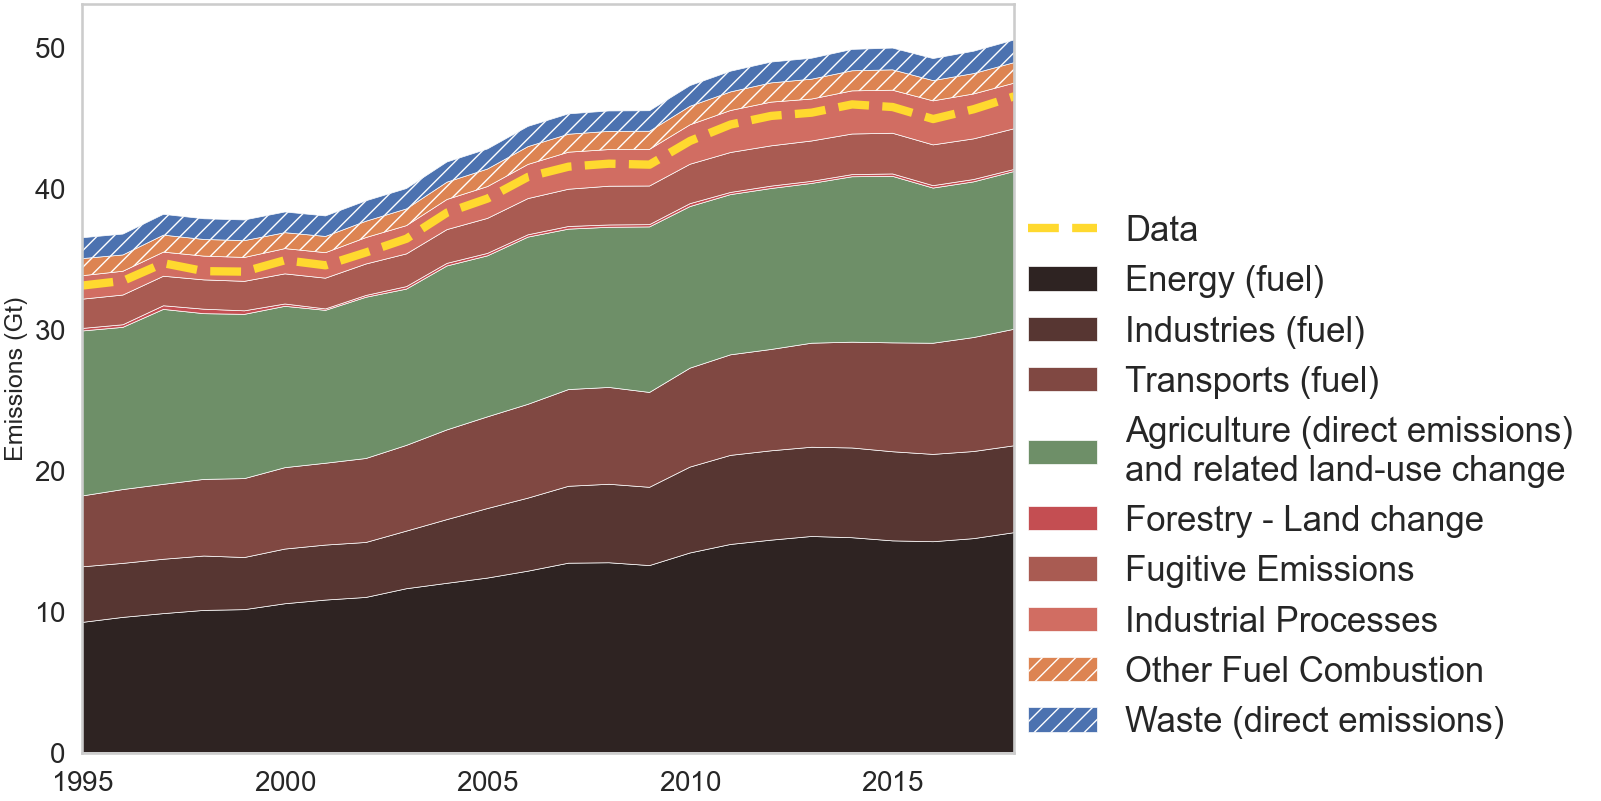

In [10]:
save = False
print('Plotting GHG distribution by categories')
years = [y for y in range(1995,2019)]

emissions_baseline = pd.read_csv('data/emissions_baseline.csv')['emissions'].values
ghg = pd.read_csv('data/climate_watch/ghg_EDGAR_ip.csv').set_index(['sector','year'])

datas = [ 'Electricity/Heat',
        'Manufacturing/Construction','Transportation','Agriculture','Forest fires',
         'Fugitive Emissions', 'Industrial Processes','Other Fuel Combustion',
        'Waste']

# labels can be changed here
labels = [ 'Energy (fuel)',
        'Industries (fuel)','Transports (fuel)','Agriculture (direct emissions) \nand related land-use change',
        'Forestry - Land change',  
         'Fugitive Emissions', 'Industrial Processes','Other Fuel Combustion',
        'Waste (direct emissions)']

to_plot = [ghg.loc[data].value for data in datas]

fig, ax = plt.subplots(figsize=(16,8),constrained_layout=True)

# colors can be changed here
palette2 = [sns.color_palette()[i] for i in [2,1,3,0]]
palette2[0] = (0.4333333333333333, 0.5588235294117647, 0.40784313725490196)
palette = [*sns.color_palette("dark:salmon_r",n_colors=6)[::-1][:5] , *palette2]
palette[3] , palette[5] = palette[5] , palette[3]
palette[4] , palette[7] = palette[7] , palette[4]
palette[6] , palette[7] = palette[7] , palette[6]

stacks = ax.stackplot(years, 
             to_plot,
             labels = labels,
                colors = palette,
                # zorder = -10,
                linewidth=0.5
             )

hatches = ['','','','','','','','//','//']
for stack, hatch in zip(stacks, hatches):
    stack.set_hatch(hatch)

plt.grid()

ax.plot(years,np.array(emissions_baseline)/1e3,ls='--',lw=6,color = sns.color_palette('Set2')[5],label = 'Data')

# I removed the line of Forest carbon sinks, can be added back by
# ax.plot(years, (-ghg.loc['Forestland']).value, ls = '--', lw=3, label = 'Forest carbon sinks \nNatural net zero target', color= 'g')

handles, labels = plt.gca().get_legend_handles_labels()

# order of areas can be changed here
order = [9,0,1,2,3,4,5,6,7,8]
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order]
          ,loc=(1,0),fontsize = 25) 
ax.margins(x=0)

ax.tick_params(axis='both', labelsize=20 )

# Title can be added here
# ax.set_title('Main greenhouse gases emissions (in Gt of CO2 equivalent)',fontsize=25,pad=15)

ax.set_ylabel('Emissions (Gt)')
# ax.set_xlabel('Years')

# plt.tight_layout()

if save or save_all:
    plt.savefig(f'{save_path}data_em_by_sector.{save_format}',format=save_format)

plt.show()


## GHG distribution over time by gas
Based on Climate watch data

Plotting GHG distribution by gas


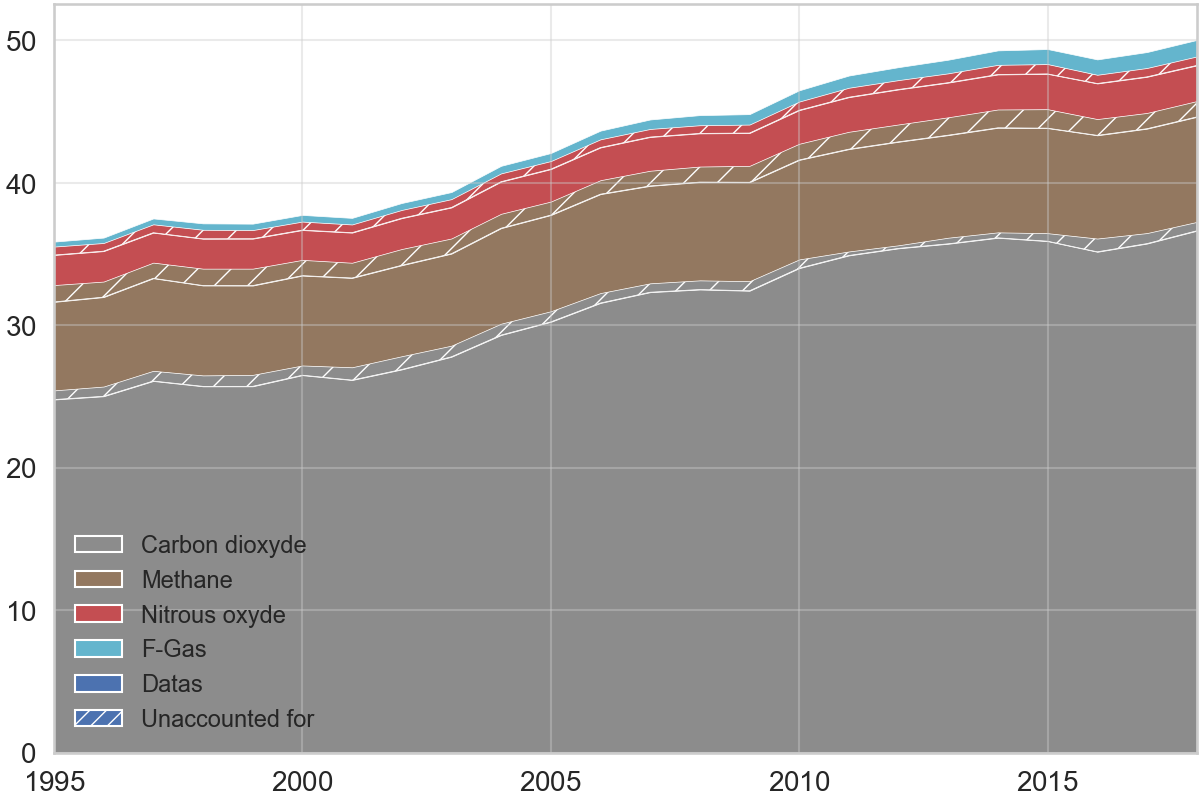

In [11]:
print('Plotting GHG distribution by gas')

save = False

carbon_prices = pd.read_csv('data/emissions_priced.csv')

ghg = pd.read_csv('data/climate_watch/ghg_EDGAR_gas.csv').set_index('gas')

datas = ['CO2_data', 'CO2', 'CH4_data', 'CH4', 'N2O_data', 'N2O','F-Gas']

to_plot = [ghg.loc[data].value for data in datas]

fig, ax = plt.subplots(figsize=(12,8),constrained_layout=True)

palette = [sns.color_palette()[i] for i in [7,7,5,5,3,3,9]]

stacks = ax.stackplot(years, 
             *to_plot,
             # labels = labels,
             colors = palette, 
             zorder = -10,
             lw = 0.5
             )
hatches = [None,'/',None,'/',None,'/',None]
for stack, hatch in zip(stacks, hatches):
    stack.set_hatch(hatch)
    
plt.grid(alpha=0.4)

# phantom plots for legend. it's dirty !
legend_labels = ['Carbon dioxyde','Methane','Nitrous oxyde','F-Gas','Datas','Unaccounted for']
legend_colors = [sns.color_palette()[i] for i in [7,5,3,9,0,0]]
legend_hatches = [None]*5+['//']
stacks_legend = ax.stackplot([],[[]*24]*6,colors = legend_colors,labels = legend_labels)
for stack_legend, hatch in zip(stacks_legend, legend_hatches):
    stack_legend.set_hatch(hatch)
    
# ax.plot(years, carbon_prices.value, ls = '--', lw=5, label = 'Emissions falling under some\ntype of carbon pricing scheme', color= 'r')    
    
ax.legend(loc='lower left'
           ,fontsize=17)

ax.margins(x=0)

ax.tick_params(axis='both', labelsize=20 )
# ax.set_title('Main greenhouse gases emissions (in Gt of CO2 equivalent)',fontsize=25,pad=15)

if save or save_all:
    plt.savefig(f'{save_path}data_em_by_gas.{save_format}',format=save_format)
    
plt.show()

## Some data about China, Brazil, the agriculture sector and the energy sector

In [168]:
df = pd.DataFrame()

df.loc['emissions agriculture','CHN'] = b.co2_prod.loc[('CHN','01T02'),'value']
df.loc['emissions intensity agriculture','CHN'] = b.co2_intensity.loc[('CHN','01T02'),'value']
df.loc['output agriculture','CHN'] = b.output.loc[('CHN','01T02'),'value']

df.loc['emissions energy','CHN'] = b.co2_prod.loc[('CHN','35'),'value']
df.loc['emissions intensity energy','CHN'] = b.co2_intensity.loc[('CHN','35'),'value']
df.loc['output energy','CHN'] = b.output.loc[('CHN','35'),'value']

df.loc['emissions agriculture','BRA'] = b.co2_prod.loc[('BRA','01T02'),'value']
df.loc['emissions intensity agriculture','BRA'] = b.co2_intensity.loc[('BRA','01T02'),'value']
df.loc['output agriculture','BRA'] = b.output.loc[('BRA','01T02'),'value']

df.loc['emissions energy','BRA'] = b.co2_prod.loc[('BRA','35'),'value']
df.loc['emissions intensity energy','BRA'] = b.co2_intensity.loc[('BRA','35'),'value']
df.loc['output energy','BRA'] = b.output.loc[('BRA','35'),'value']

df.loc['emissions agriculture','World'] = b.co2_prod.groupby('sector').sum().loc['01T02','value']
df.loc['emissions intensity agriculture','World'] = b.co2_prod.groupby('sector').sum().loc['01T02','value']*1e6/b.output.groupby('sector').sum().loc['01T02','value']
df.loc['output agriculture','World'] = b.output.groupby('sector').sum().loc['01T02','value']

df.loc['emissions energy','World'] = b.co2_prod.groupby('sector').sum().loc['35','value']
df.loc['emissions intensity energy','World'] = b.co2_prod.groupby('sector').sum().loc['35','value']*1e6/b.output.groupby('sector').sum().loc['35','value']
df.loc['output energy','World'] = b.output.groupby('sector').sum().loc['35','value']

df['CHN/World (percentage)'] = df['CHN']*100/df['World']
df['BRA/World (percentage)'] = df['BRA']*100/df['World']

df.round(2).to_csv(save_path+'some_data_facts_about_china_brazil_agriculture_energy.csv')

# Results

## Load solutions for different carbon taxes

In [5]:
carb_cost_list = np.linspace(0,1e-3,1001)
eta_path = [elasticities_path]
sigma_path = [elasticities_path]
taxed_countries_list = [None]
taxing_countries_list = [None]
taxed_sectors_list = [None]
specific_taxing_list = [None]
fair_tax_list = [False]
pol_pay_tax_list = [False]
tau_factor_list = [1]
tax_scheme_list = [tax_scheme]
y  = 2018
year = str(y)
years = [y]
dir_num = dir_num_numeraire[numeraire]

cases = d.build_cases(eta_path,sigma_path,carb_cost_list,taxed_countries_list,taxing_countries_list,
                      taxed_sectors_list,specific_taxing_list,fair_tax_list,
                      pol_pay_tax_list,tax_scheme_list,tau_factor_list)

sols, baselines, relevant_runs, found_cases, not_found_cases = t.sol.load_sols(cases,
                                                      years,
                                                      dir_num,
                                                      results_path,
                                                      data_path,
                                                      baselines = {2018:b},
                                                      compute_sols = True,
                                                      # compute_hats= True,
                                                      return_not_found_cases=True,
                                                      drop_duplicate_runs=True,
                                                      keep='last')

t_index = np.argmin(np.abs(np.array([sol.params.carb_cost for sol in sols])-1e-4))
sol = sols[t_index]

191 cases found out of 1001
Found cases for 1 years
Years not found : []


100%|█████████████████████████████████████| 191/191 [00:14<00:00, 13.37it/s]


In [13]:
#%% compute trade and share traded

trade = baselines[y].iot.groupby(level=[0,1,2]).sum()
trade['cons'] = baselines[y].cons.value
trade['baseline'] = trade.value + trade.cons
trade = trade[['baseline']]
print("Computing trade")
l_trade = []
for i,sol_temp in enumerate(sols):
    l_trade.append(sol_temp.iot.value.values.reshape((N,S,N,S)).sum(axis=-1).ravel()
                   + sol_temp.cons.value.values )

trades = pd.concat([pd.Series(l_t) for l_t in l_trade],axis=1)
trades.index = trade.index
trade = pd.concat([trade,trades],axis=1)

print('Computing share of output traded')

iot_traded_unit = b.iot.copy()
iot_traded_unit['value'] = 1
iot_traded_unit.loc[iot_traded_unit.query("row_country == col_country").index, 'value'] = 0
cons_traded_unit = b.cons.copy()
cons_traded_unit['value'] = 1
cons_traded_unit.loc[cons_traded_unit.query("row_country == col_country").index, 'value'] = 0

share_traded = np.array([((sol.cons.value.to_numpy() * cons_traded_unit.value.to_numpy()).sum() + (sol.iot.value.to_numpy()  * iot_traded_unit.value.to_numpy()).sum())*100 /\
                         (sol.cons.value.to_numpy().sum()+sol.iot.value.to_numpy().sum()) for sol in sols])

total_output = np.array([sol.output.sum() for sol in sols])

Computing trade
Computing share of output traded


## Plot macro effects

Plotting welfare and GDP cost corresponding to a carbon tax


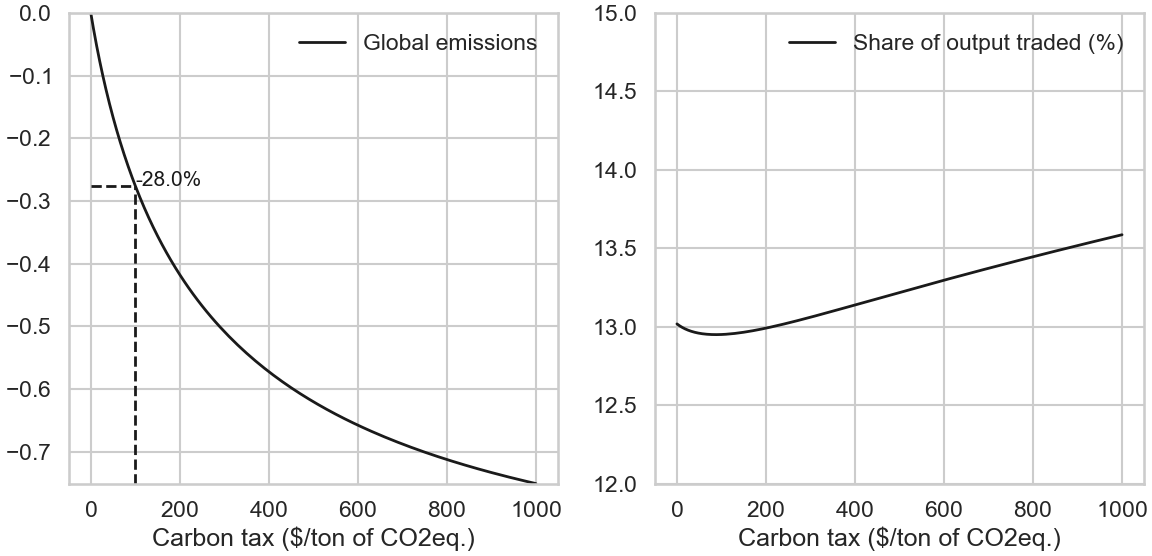

In [14]:
save = True

print('Plotting welfare and GDP cost corresponding to a carbon tax')

carb_taxes = np.array([sol.params.carb_cost*1e6  for sol in sols])
norm_emissions = np.array([sol.co2_prod.value.sum()
                            /baselines[y].co2_prod.value.sum() 
                           for sol in sols])-1
norm_emissions_real = np.array([sol.run.emissions/baselines[y].co2_prod.value.sum() for sol in sols])
norm_gdp = np.array([sol.va.value.sum()/baselines[y].va.value.sum() for sol in sols])
norm_real_income = np.array([sol.run.utility for sol in sols])
norm_total_output = np.array([sol.output.value.sum()/baselines[y].output.value.sum() for sol in sols])

fig, ax = plt.subplots(1,2,figsize=(12,6))

ax[1].plot(carb_taxes,share_traded,lw=2,color='k')

ax[1].legend(['Share of output traded (%)'])

ax[1].margins(y=0)

ax[1].set_ylim(12,15)

ax[1].set_xlabel('Carbon tax ($/ton of CO2eq.)')

color = 'k'

ax[0].plot(carb_taxes,norm_emissions,lw=2,color=color)
ax[0].legend(['Global emissions'])
ax[0].set_xlabel('Carbon tax ($/ton of CO2eq.)')

y_100 = norm_emissions[np.argmin(np.abs(carb_taxes-100))]

ax[0].vlines(x=100,
            ymin=norm_emissions.min(),
            ymax=y_100,
            lw=2,
            ls = '--',
            color = color)

ax[0].hlines(y=y_100,
            xmin=0,
            xmax=100,
            lw=2,
            ls = '--',
            color = color)

ax[0].margins(y=0)

ax[0].set_ylim(norm_emissions.min(),norm_emissions.max()*1.005)

ax[0].annotate(str((100*(y_100)).round(0))+'%',
              xy=(100,y_100),
              xytext=(0,0),
                 fontsize=15,
              textcoords='offset points',color=color)

plt.tight_layout()

if save or save_all:
    plt.savefig(save_path+'macro_effects.'+save_format,format=save_format)
plt.show()

## Compute decomposition

In [21]:
#%% compute decomposition

def X(trade):
    res = np.einsum('isj->',
                  trade)
    return res

def alpha_s(trade):
    num = np.einsum('isj->s',trade)
    denom = trade.sum()
    return num/denom

def alpha_is(trade):
    num = np.einsum('isj->is',trade)
    denom = np.einsum('isj->s',trade)
    return np.einsum('is,s->is',num,1/denom)

def e_s(trade,e):
    return np.einsum('is,is->s',alpha_is(trade),e)

def e_scal(trade,e):
    return np.einsum('s,s->',alpha_s(trade),e_s(trade,e))

def epsilon_s(trade,e):
    return np.einsum('s,s,,->s',
                     np.einsum('isj->s',trade),
                     e_s(trade,e),
                     1/np.einsum('isj->',trade),
                     1/e_scal(trade,e))

def epsilon_is(trade,e):
    return np.einsum('is,is,,->is',
                     np.einsum('isj->is',trade),
                     e,
                     1/np.einsum('isj->',trade),
                     1/e_scal(trade,e))

l_term_1 = []
l_term_2 = []
l_term_3 = []

l_em_reduc = []
e = b.co2_intensity.value.values.reshape((N,S))
print("Computing decomposition")
for i in range(len(sols)-1):
    trade_baseline = trade[i].values.reshape((N,S,N))
    # trade_baseline = trade['baseline'].values.reshape((N,S,N))
    trade_cf = trade[i+1].values.reshape((N,S,N)) 
    
    term_1 = (X(trade_cf) - X(trade_baseline))/X(trade_baseline)

    term_2 = np.einsum('s,s,s->s',
                       epsilon_s(trade_baseline,e),
                       alpha_s(trade_cf)-alpha_s(trade_baseline),
                       1/alpha_s(trade_baseline))

    term_3 = np.einsum('is,is,is->is',
               epsilon_is(trade_baseline,e),
               alpha_is(trade_cf)-alpha_is(trade_baseline),
               1/alpha_is(trade_baseline))

    em_reduc = (np.einsum('isj,is->',
                         trade_cf,
                         e)-\
                np.einsum('isj,is->',
                          trade_baseline,
                          e))/np.einsum('isj,is->',
                                    trade_baseline,
                                    e)
                                        
    l_term_1.append(term_1)
    l_term_2.append(term_2)
    l_term_3.append(term_3)
    l_em_reduc.append(em_reduc)

l_term_1 = np.array(l_term_1)
l_term_2 = np.array(l_term_2)
l_term_3 = np.array(l_term_3)

l_em_reduc = np.array(l_em_reduc)
    
d_term = {
    'term_1':l_term_1,
    'term_2':l_term_2,
    'term_3':l_term_3,
          }

d_term_summed = {key: [v.sum() for v in l_term] for key, l_term in d_term.items()}

emiss_reduc_contrib = {}
for term, l_term in d_term_summed.items():
    emiss_reduc_contrib[term] = np.array([l_term[k]*sols[k].co2_prod.value.sum()/b.co2_prod.value.sum() 
                                 for k in range(len(l_term))])
    
l_em_incr = np.array([l_em_reduc[k]*sols[k].co2_prod.value.sum()/b.co2_prod.value.sum() 
             for k in range(len(l_em_reduc))])


term_labels = {
    'term_1':'Scale',
    'term_2':'Composition',
    'term_3':'Green sourcing'
          }

Computing decomposition


## Plot decomposition

In [23]:
[term for term in cumul_terms.values()]

[array([ 0.00000000e+00, -5.89814687e-05, -1.17755101e-04, -1.76285788e-04,
        -2.34554066e-04, -2.92548384e-04, -3.50261567e-04, -4.07689027e-04,
        -4.64827809e-04, -5.21676027e-04, -5.78232535e-04, -6.34496717e-04,
        -6.90468352e-04, -7.46147522e-04, -8.01534545e-04, -8.56629938e-04,
        -9.11434376e-04, -9.65948672e-04, -1.02017375e-03, -1.07411065e-03,
        -1.12776048e-03, -1.18112444e-03, -1.23420380e-03, -1.28699989e-03,
        -1.33951409e-03, -1.39174783e-03, -1.44370261e-03, -1.49537995e-03,
        -1.54678139e-03, -1.59790854e-03, -1.64876302e-03, -1.69934647e-03,
        -1.74966057e-03, -1.79970702e-03, -1.84948751e-03, -1.89900379e-03,
        -1.94825760e-03, -1.99725069e-03, -2.04598482e-03, -2.09446177e-03,
        -2.14268332e-03, -2.19065126e-03, -2.23836737e-03, -2.28583345e-03,
        -2.33305129e-03, -2.38002269e-03, -2.42674943e-03, -2.47323332e-03,
        -2.51947614e-03, -2.56547967e-03, -2.61124570e-03, -2.65677599e-03,
        -2.7

/var/folders/9z/_4pclxyj4ps7nxcwmqxlhkx17x8ksk/T/ipykernel_78947/547424618.py:23: RuntimeWarning: invalid value encountered in divide
  y = [-term/sum_terms for term in cumul_terms.values()]


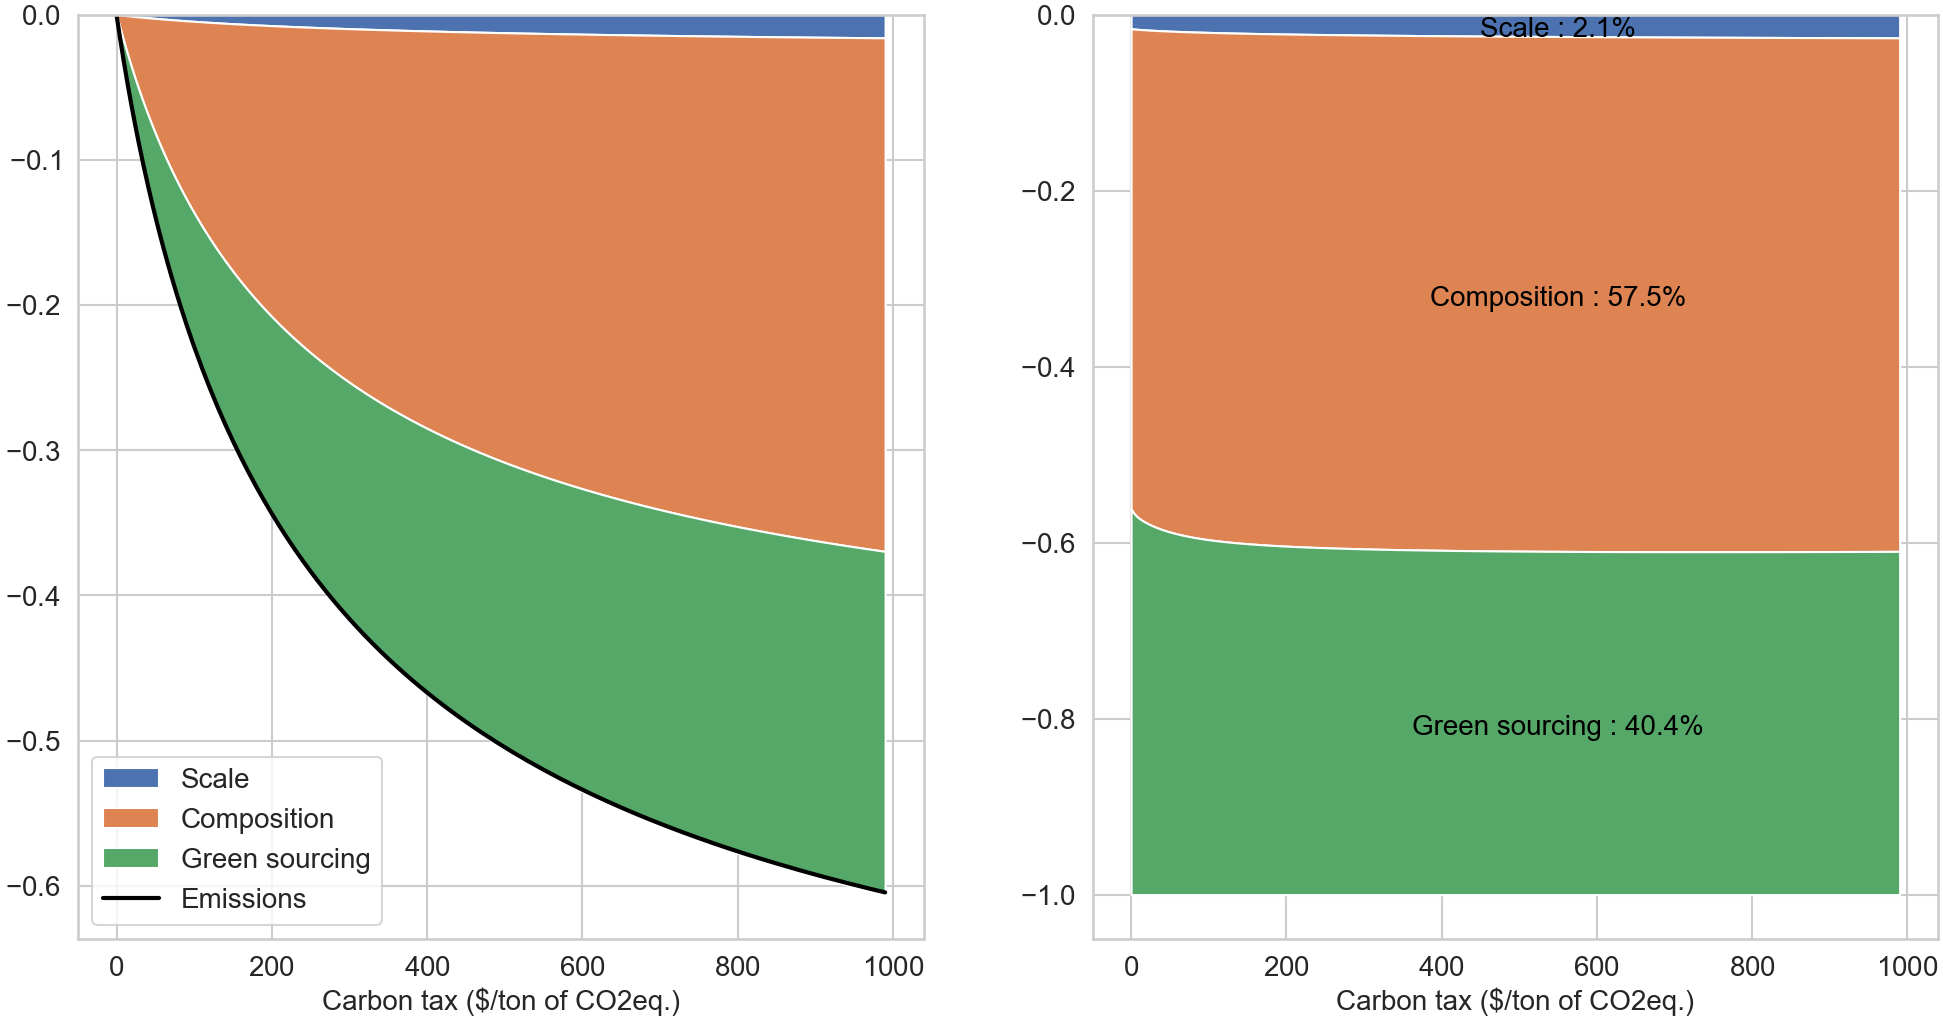

In [25]:
cumul_terms = {key: np.array([value[:i].sum()
                      for i in range(len(value))]) for key, value in emiss_reduc_contrib.items()}

fig,ax = plt.subplots(1,2,figsize = (24, 12))

ax[0].stackplot(carb_taxes[:-1],
              [term for term in cumul_terms.values()],
              labels=[term_labels[term] for term in cumul_terms.keys()])
ax[0].plot(carb_taxes[:-1],[l_em_incr[:i].sum() for i in range(len(l_em_incr))], 
          label='Emissions',color='black'
          ,lw=3)
ax[0].legend(loc='lower left',fontsize = 20, frameon=True, fancybox=True)
ax[0].tick_params(axis='both', which='major', labelsize=20)
ax[0].set_xlabel('Carbon tax ($/ton of CO2eq.)',fontsize = 20)

#%% plot decomposition normalized

cumul_terms = {key: np.array([value[:i].sum()
                      for i in range(len(value))]) for key, value in emiss_reduc_contrib.items()}

sum_terms = cumul_terms['term_1']+cumul_terms['term_2']+cumul_terms['term_3']

y = [-term/sum_terms for term in cumul_terms.values()]
for temp in y:
    temp[0] = temp[1]

ax[1].stackplot(carb_taxes[:-1],
              y,
              labels=[term_labels[term] for term in cumul_terms.keys()])

offset = -0.005
for name,term in cumul_terms.items():
    loc = 145
    ax[1].text(carb_taxes[:-1][loc], -(term[1:]/sum_terms[1:])[loc]/2+offset, term_labels[name]+' : '+str(((term[1:]/sum_terms[1:]).mean()*100).round(1))+'%',
            ha='center', va='center',color='black',fontsize = 20)
    offset = offset-(term[1:]/sum_terms[1:])[loc]
    
ax[1].tick_params(axis='both', which='major', labelsize=20)
ax[1].set_xlabel('Carbon tax ($/ton of CO2eq.)',fontsize = 20)

if save or save_all:
    plt.savefig(save_path+'decomposition.'+save_format,format=save_format)
plt.show()

## Compute real decomposition

In [ ]:
#%% compute decomposition

def Q_hat(sol,baseline):
    res = np.einsum('is,is->',
                    sol.q_hat.value.values.reshape(N,S),
                    baseline.output_np
                    )
    return res

def Q_s_hat(sol,baseline):
    res = np.einsum('is,is->s',
                    sol.q_hat.value.values.reshape(N,S),
                    baseline.output_np
                    )
    return res

def Q_is_hat(sol,baseline):
    res = sol.q_hat.value.values.reshape(N,S)
    return res

def E(sol):
    res = sol.co2_prod.value.sum()
    return res

def E_s(sol):
    res = sol.co2_prod.value.groupby('sector').sum().values
    return res

def E_is(sol):
    res = sol.co2_prod.value.values.reshape(N,S)
    return res

l_dterm_1 = []
l_dterm_2 = []
l_dterm_3 = []
l_dE = []

for i in tqdm(range(len(sols)-1)):
    # print(i)
    sol_baseline = sols[i]
    sol_cf = sols[i+1]
    
    term_1 = E(sol_baseline)*(Q_hat(sol_cf,b)/Q_hat(sol_baseline,b) - 1)

    term_2 = np.einsum('s,s->',
        E_s(sol_baseline),
        Q_s_hat(sol_cf,b)*Q_hat(sol_baseline,b)
            /(Q_hat(sol_cf,b)*Q_s_hat(sol_baseline,b)) - 1
        )
    
    term_3 = np.einsum('is,is->',
        E_is(sol_baseline),
        Q_is_hat(sol_cf,b)*Q_s_hat(sol_baseline,b)
            /(Q_s_hat(sol_cf,b)*Q_is_hat(sol_baseline,b)) - 1
        )
    
    dE = sol_cf.co2_prod.value.sum() - sol_baseline.co2_prod.value.sum()
    
    l_dterm_1.append(term_1)
    l_dterm_2.append(term_2)
    l_dterm_3.append(term_3)
    l_dE.append(dE)
    
l_term_1 = np.array([sum(l_dterm_1[:i]) for i in range(len(l_dterm_1)+1)])
l_term_2 = np.array([sum(l_dterm_2[:i]) for i in range(len(l_dterm_2)+1)])
l_term_3 = np.array([sum(l_dterm_3[:i]) for i in range(len(l_dterm_3)+1)])
l_deltaE = np.array([sum(l_dE[:i]) for i in range(len(l_dE)+1)])


## Plot real decomposition

/var/folders/9z/_4pclxyj4ps7nxcwmqxlhkx17x8ksk/T/ipykernel_21613/3895783792.py:24: RuntimeWarning: invalid value encountered in divide
  y = [-term/sum_terms for term in [l_term_1,l_term_2,l_term_3]]


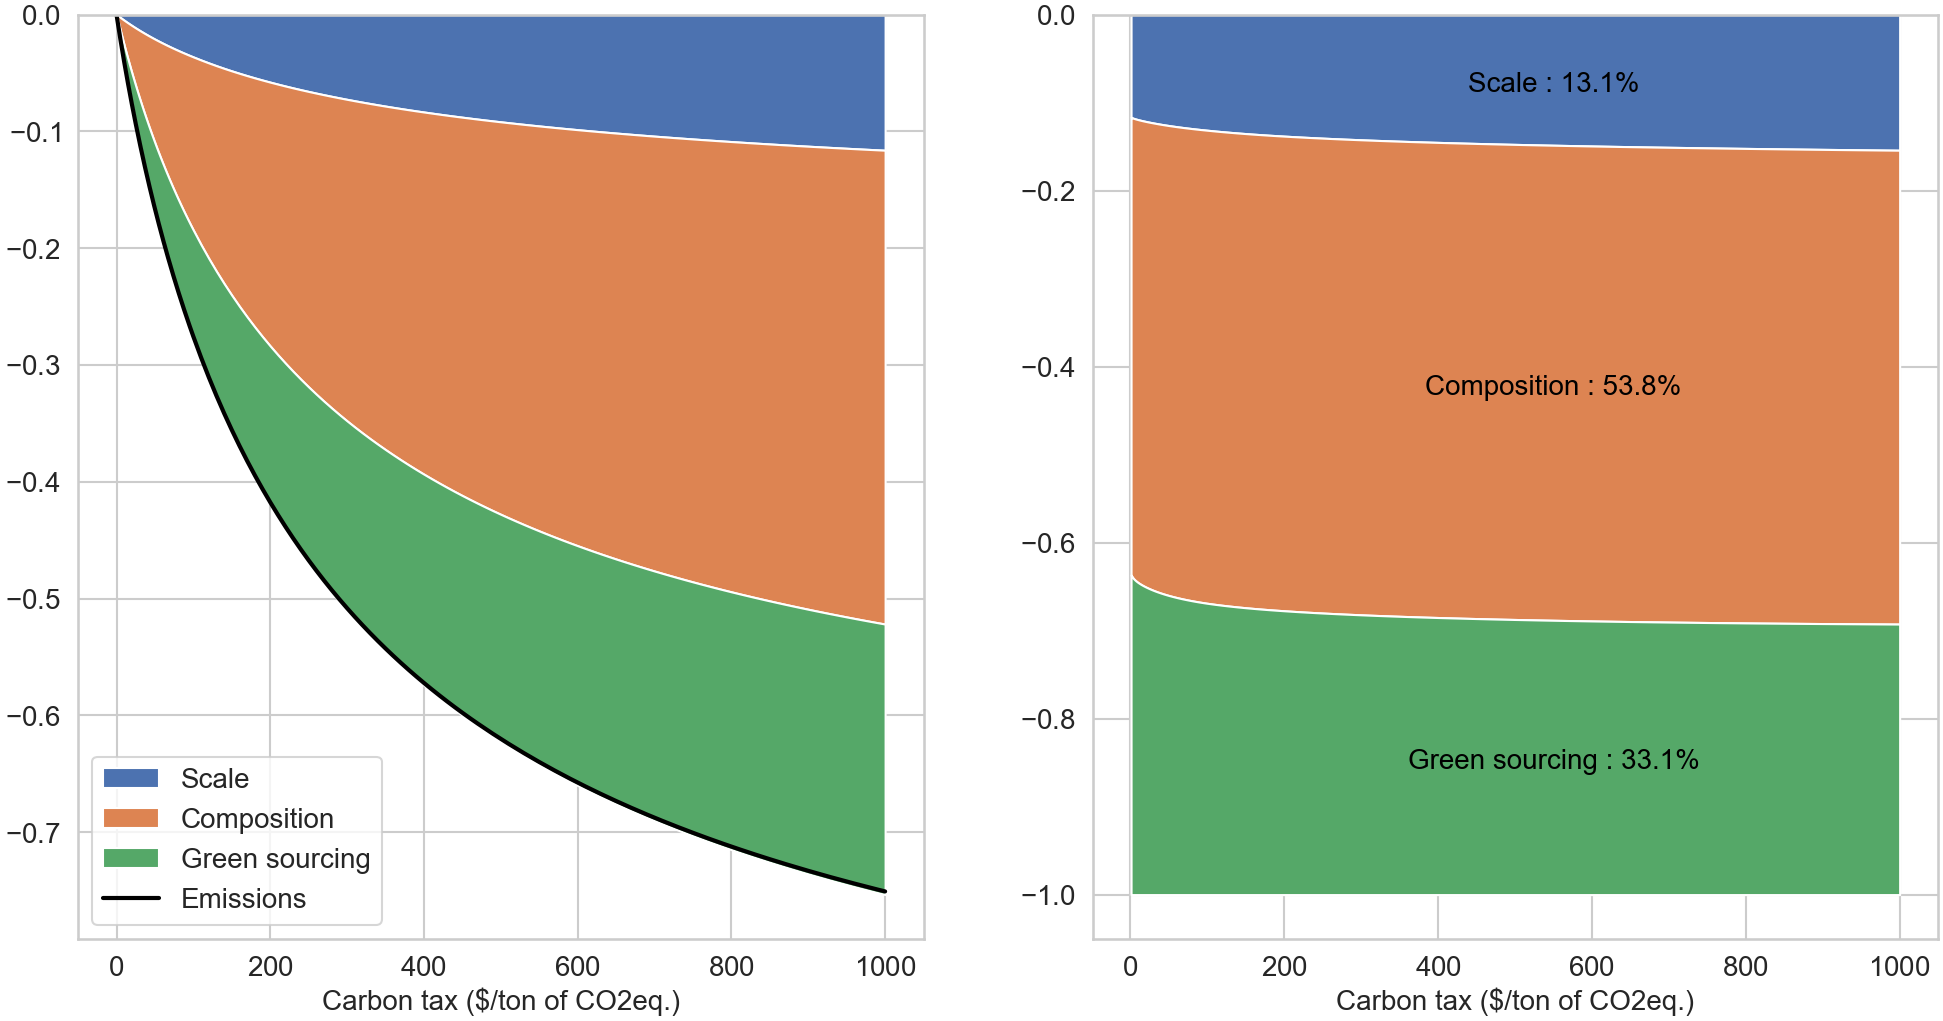

In [23]:
save=True

term_labels = {
    'term_1':'Scale',
    'term_2':'Composition',
    'term_3':'Green sourcing'
          }
carb_taxes = np.array([sol.params.carb_cost*1e6  for sol in sols])

fig,ax = plt.subplots(1,2,figsize = (24, 12))

ax[0].stackplot(carb_taxes,
              [term/b.co2_prod.value.sum() for term in [l_term_1,l_term_2,l_term_3]],
              labels=[term_labels[term] for term in term_labels.keys()])
ax[0].plot(carb_taxes,l_deltaE/b.co2_prod.value.sum(), 
          label='Emissions',color='black'
          ,lw=3)
ax[0].legend(loc='lower left',fontsize = 20, frameon=True, fancybox=True)
ax[0].tick_params(axis='both', which='major', labelsize=20)
ax[0].set_xlabel('Carbon tax ($/ton of CO2eq.)',fontsize = 20)

sum_terms = l_term_1+l_term_2+l_term_3

y = [-term/sum_terms for term in [l_term_1,l_term_2,l_term_3]]

ax[1].stackplot(carb_taxes,y,
              labels=[term_labels[term] for term in term_labels.keys()])

offset = -0.005
for i,term_label in enumerate(term_labels.values()):
    term = [l_term_1,l_term_2,l_term_3][i]
    loc = 145
    ax[1].text(carb_taxes[loc], 
               -(term[loc]/sum_terms[loc])/2+offset, 
               term_label+' : '+str(((term[99]/sum_terms[99]).mean()*100).round(1))+'%',
               ha='center', va='center',color='black',fontsize = 20)
    offset = offset-(term[1:]/sum_terms[1:])[loc]
    
ax[1].tick_params(axis='both', which='major', labelsize=20)
ax[1].set_xlabel('Carbon tax ($/ton of CO2eq.)',fontsize = 20)

if save or save_all:
    plt.savefig(save_path+'real_decomposition.'+save_format,format=save_format)
plt.show()

## Pie charts of terms 3 inside sectors

In [26]:
sector_map = pd.read_csv(data_path+'industry_labels_after_agg_expl_wgroup.csv')
sector_map['sector'] = sector_map['ind_code'].str.replace('D','')
sector_map.set_index('sector',inplace=True)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 

pio.templates[pio.templates.default].layout.colorway = [sns.color_palette("deep").as_hex()[i-2] for i in range(3)]

scaling = 1

for i,sector in enumerate(b.sector_list):
    print(sector_map.loc[sector,'industry'])
    fig3 = make_subplots(rows=1, cols=2, 
                         specs=[[{"type": "sunburst"}, {"type": "sunburst"}]],
                         horizontal_spacing=0.01)

    trade_baseline = trade['baseline'].values.reshape((N,S,N))
    trade_cf = trade[100].values.reshape((N,S,N)) 

    data_base = pd.DataFrame(columns=['term','spec1','spec2','value']).set_index(['term','spec1','spec2'])

    term3 = np.einsum('is->is',
                       alpha_is(trade_cf)-alpha_is(trade_baseline))

    # for i,sector in enumerate(b.sector_list):
    #     for j, country in enumerate(b.country_list):
    #         data_base.loc[('Expenditure share decrease',sector_map.loc['D'+sector,'industry'],country),'value'] = term3[j,i]*100

    for j, country in enumerate(b.country_list):
        if country!='TWN':
            data_base.loc[('Expenditure share decrease',sector_map.loc[sector,'industry'],country),'value'] = term3[j,i]*100

    total = data_base.loc[data_base.value>0, 'value'].sum()

    data_base.reset_index(inplace = True)
    data_base['d(alpha)'] = data_base['value']
    data_base.loc[data_base.value>0, 'term'] = data_base.loc[data_base.value>0, 'term'].str.replace('decrease','increase')
    data_base.set_index(['term','spec1','spec2'],inplace=True)
    data_base.sort_index(inplace=True)
    data_base.value = np.abs(data_base.value)
    data_base.reset_index(inplace = True)
    data_base = data_base.replace('',None)
    data_base['value'] = data_base['value']*total/data_base['value'].sum()
    
    data_base = data_base.sort_values(['term','d(alpha)'])
    
    pio.renderers.default='browser'
    color_discrete_map = {
        'Expenditure share decrease':sns.color_palette().as_hex()[3],
        'Expenditure share increase':sns.color_palette().as_hex()[2],
        }

    hover_data = {'term':False
                  , 'spec1':False
                  , 'spec2':False
                  , 'value':True
                  , 'd(alpha)':True}
    
    fig1 = px.sunburst(data_base, path=['spec1', 'spec2'], values='value', color='term',
                        color_discrete_map=color_discrete_map,
                        hover_data = hover_data,
                        )
    fig1.update_traces(textinfo="label+value",
                       texttemplate="%{label}<br>%{value:.2f}%")
    # fig1.update_traces(sort=False, selector=dict(type='sunburst')) 
    fig1.update_layout(
        margin=dict(l=0, r=0, t=0, b=0),
    )

    fig3.add_trace(fig1.data[0],
        row=1, col=1)


    trade_baseline = trade['baseline'].values.reshape((N,S,N))
    trade_cf = trade[100].values.reshape((N,S,N)) 

    data_base2 = pd.DataFrame(columns=['term','spec1','spec2','value']).set_index(['term','spec1','spec2'])

    term3 = np.einsum('is,is,is->is',
                       epsilon_is(trade_baseline,e),
                       alpha_is(trade_cf)-alpha_is(trade_baseline),
                       1/alpha_is(trade_baseline))

    # for i,sector in enumerate(b.sector_list):
    #     for j, country in enumerate(b.country_list):
    #         data_base2.loc[('Emissions decrease',sector_map.loc['D'+sector,'industry'],country),'value'] = term3[j,i]*100

    for j, country in enumerate(b.country_list):
        if country!='TWN':
            data_base2.loc[('Emissions decrease',sector_map.loc[sector,'industry'],country),'value'] = term3[j,i]*100

    data_base2.sort_index(inplace=True)
    em_saved = data_base2.loc[data_base2.value>0].groupby(level=[0,1])['value'].sum() + data_base2.loc[data_base2.value<0].groupby(level=[0,1])['value'].sum()
    data_base2['value'] = data_base2['value']*np.abs(em_saved/data_base2.groupby(level=[0,1])['value'].sum())
    
    data_base2 = data_base2*b.co2_prod.value.sum()/b.co2_prod.groupby('sector').sum().loc[sector,'value']
    
    data_base2.reset_index(inplace = True)
    data_base2['dE/E'] = data_base2['value']
    data_base2.loc[data_base2.value>0, 'term'] = data_base2.loc[data_base2.value>0, 'term'].str.replace('decrease','increase')
    data_base2.value = np.abs(data_base2.value)
    data_base2 = data_base2.replace('',None)
    
    data_base2 = data_base2.sort_values('dE/E')

    pio.renderers.default='browser'
    color_discrete_map = {
        'Emissions decrease':sns.color_palette().as_hex()[3],
        'Emissions increase':sns.color_palette().as_hex()[2],
        }

    hover_data = {'term':False
                  , 'spec1':False
                  , 'spec2':False
                  , 'value':True
                  # , 'value disp':True
                  , 'dE/E':True}


    fig2 = px.sunburst(data_base2, path=['spec1','spec2'], values='value', color='term',
                       # template = 'plotly_dark_custom',
                       hover_data = hover_data,
                        color_discrete_map=color_discrete_map)
    fig2.update_traces(textinfo="label+value",
                       texttemplate="%{label}<br>%{value:.2f}%")
    # fig2.update_traces(sort=False, selector=dict(type='sunburst')) 
    fig2.update_layout(
        margin=dict(l=0, r=0, t=0, b=0),
    )
    
    
    fig3.add_trace(fig2.data[0],
        row=1, col=2)

    fig3.update_layout(
        font=dict(
            size=30, 
        )
    )

    scaling = 1/2
    fig3.update_layout(
        margin=dict(l=0, r=0, t=0, b=0),
        annotations=[
        dict(
            text="Emissions reallocation",  # The title text
            x=0.84,  # Position x relative to the whole figure
            y=0.9,  # Position y relative to the whole figure
            # xref="paper",
            # yref="paper",
            showarrow=False,
            font=dict(size=35)  # Font size for the title
        ),
            dict(
            text="Output reallocation",  # The title text
            x=0.16,  # Position x relative to the whole figure
            y=0.9,  # Position y relative to the whole figure
            # xref="paper",
            # yref="paper",
            showarrow=False,
            font=dict(size=35)  # Font size for the title
        )
    ]
    )

    pio.write_image(fig3,save_path_sunbursts+sector_map.loc[sector,'industry']+'_term_3_sunburst.pdf', format='pdf', 
                    # engine='orca',
                    width=4000*scaling,height=4000*scaling*21/29.7)
    # fig3.write_html(save_path_sunbursts+sector_map.loc[sector,'industry']+'_term_3_sunburst.html')
    # fig3.show()

Agriculture
Fishing
Mining, energy
Mining, non-energy
Food products
Textiles
Wood
Paper
Coke
Chemicals
Pharmaceuticals
Plastics
Non-metallic minerals
Basic metals
Fabricated metals
Electronic
Electrical equipment
Machinery
Transport equipments
Manufacturing nec
Energy
Water supply
Construction
Wholesale, retail
Land transport
Water transport
Air transport
Warehousing
Post
Tourism
Media
Telecom
IT
Finance, insurance
Real estate
R&D
Administration
Public sector
Education
Health
Entertainment
Other service


# Incremental tax countries / sectors !No robustness checks

<!-- ## Define functions to compute decomposition -->

In [27]:
# def X(trade):
#     res = np.einsum('isj->',
#                   trade)
#     return res

# def alpha_s(trade):
#     num = np.einsum('isj->s',trade)
#     denom = trade.sum()
#     return num/denom

# def alpha_is(trade):
#     num = np.einsum('isj->is',trade)
#     denom = np.einsum('isj->s',trade)
#     return np.einsum('is,s->is',num,1/denom)

# def e_s(trade,e):
#     return np.einsum('is,is->s',alpha_is(trade),e)

# def e_scal(trade,e):
#     return np.einsum('s,s->',alpha_s(trade),e_s(trade,e))

# def epsilon_s(trade,e):
#     return np.einsum('s,s,,->s',
#                      np.einsum('isj->s',trade),
#                      e_s(trade,e),
#                      1/np.einsum('isj->',trade),
#                      1/e_scal(trade,e))

# def epsilon_is(trade,e):
#     return np.einsum('is,is,,->is',
#                      np.einsum('isj->is',trade),
#                      e,
#                      1/np.einsum('isj->',trade),
#                      1/e_scal(trade,e))
    
# def compute_decomposition_at_100_for_list_of_sols(sols_by_carb_cost,baseline):
#     l_term_1 = []
#     l_term_2 = []
#     l_term_3 = []
#     for i in range(1,len(sols_by_carb_cost)):
#         sol_b = sols_by_carb_cost[i-1].compute_solution(baseline,with_np_arrays=True)
#         sol_cf = sols_by_carb_cost[i].compute_solution(baseline,with_np_arrays=True)
#         trade_baseline = sol_b.trade_np
#         trade_cf = sol_cf.trade_np
        
#         term_1 = (X(trade_cf) - X(trade_baseline))/X(trade_baseline)

#         term_2 = np.einsum('s,s,s->s',
#                            epsilon_s(trade_baseline,e),
#                            alpha_s(trade_cf)-alpha_s(trade_baseline),
#                            1/alpha_s(trade_baseline))

#         term_3 = np.einsum('is,is,is->is',
#                    epsilon_is(trade_baseline,e),
#                    alpha_is(trade_cf)-alpha_is(trade_baseline),
#                    1/alpha_is(trade_baseline))

#         l_term_1.append(term_1)
#         l_term_2.append(term_2)
#         l_term_3.append(term_3)
        
#     l_term_1 = np.array(l_term_1)
#     l_term_2 = np.array(l_term_2)
#     l_term_3 = np.array(l_term_3)
    
#     d_term = {
#         'term_1':l_term_1,
#         'term_2':l_term_2,
#         'term_3':l_term_3,
#               }
    
#     d_term_summed = {key: [v.sum() for v in l_term] for key, l_term in d_term.items()}
    
#     emiss_reduc_contrib = {}
#     for term, l_term in d_term_summed.items():
#         emiss_reduc_contrib[term] = np.array([l_term[k]*sols_by_carb_cost[k].run.emissions/baseline.co2_prod.value.sum() 
#                                       for k in range(len(l_term))])
#     return emiss_reduc_contrib

## Define functions to compute real decomposition

In [86]:
compute_decomposition_at_100_for_list_of_sols(sols_by_carb_cost,baseline)

100%|███████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.43it/s]


{'term_1': array([-1686.82009148]),
 'term_2': array([-6900.72466818]),
 'term_3': array([-4249.62006315])}

In [88]:
(-4249)/(-1686.82009148-6900-4249)

0.33102676492173244

In [72]:
sols = sols_by_carb_cost

In [76]:
sols[0].compute_solution(b).elements()

co2_prod , pandas.core.frame.DataFrame
cons , pandas.core.frame.DataFrame
consumer_price_agg , pandas.core.frame.DataFrame
contrib , NoneType
iot , pandas.core.frame.DataFrame
output , pandas.core.frame.DataFrame
params , lib.data_funcs.params
price , pandas.core.frame.DataFrame
producer_price_agg , pandas.core.frame.DataFrame
q_hat , pandas.core.frame.DataFrame
res , pandas.core.frame.DataFrame
results_path , str
run , pandas.core.series.Series
taxed_price , pandas.core.frame.DataFrame
utility , pandas.core.frame.DataFrame
va , pandas.core.frame.DataFrame


In [77]:
#%% compute decomposition

def Q_hat(sol,baseline):
    res = np.einsum('is,is->',
                    sol.q_hat.value.values.reshape(N,S),
                    baseline.output_np
                    )
    return res

def Q_s_hat(sol,baseline):
    res = np.einsum('is,is->s',
                    sol.q_hat.value.values.reshape(N,S),
                    baseline.output_np
                    )
    return res

def Q_is_hat(sol,baseline):
    res = sol.q_hat.value.values.reshape(N,S)
    return res

def E(sol):
    res = sol.co2_prod.value.sum()
    return res

def E_s(sol):
    res = sol.co2_prod.value.groupby('sector').sum().values
    return res

def E_is(sol):
    res = sol.co2_prod.value.values.reshape(N,S)
    return res

l_dterm_1 = []
l_dterm_2 = []
l_dterm_3 = []
l_dE = []

for i in tqdm(range(len(sols)-1)):
    # print(i)
    sol_baseline = sols[i].compute_solution(b)
    sol_cf = sols[i+1].compute_solution(b)
    
    term_1 = E(sol_baseline)*(Q_hat(sol_cf,b)/Q_hat(sol_baseline,b) - 1)

    term_2 = np.einsum('s,s->',
        E_s(sol_baseline),
        Q_s_hat(sol_cf,b)*Q_hat(sol_baseline,b)
            /(Q_hat(sol_cf,b)*Q_s_hat(sol_baseline,b)) - 1
        )
    
    term_3 = np.einsum('is,is->',
        E_is(sol_baseline),
        Q_is_hat(sol_cf,b)*Q_s_hat(sol_baseline,b)
            /(Q_s_hat(sol_cf,b)*Q_is_hat(sol_baseline,b)) - 1
        )
    
    # dE = sol_cf.co2_prod.value.sum() - sol_baseline.co2_prod.value.sum()
    
    l_dterm_1.append(term_1)
    l_dterm_2.append(term_2)
    l_dterm_3.append(term_3)
    # l_dE.append(dE)
    
l_term_1 = np.array([sum(l_dterm_1[:i]) for i in range(len(l_dterm_1)+1)])
l_term_2 = np.array([sum(l_dterm_2[:i]) for i in range(len(l_dterm_2)+1)])
l_term_3 = np.array([sum(l_dterm_3[:i]) for i in range(len(l_dterm_3)+1)])
l_deltaE = np.array([sum(l_dE[:i]) for i in range(len(l_dE)+1)])


100%|███████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.41it/s]


In [83]:
(l_term_3/(l_term_1+l_term_2+l_term_3))

/var/folders/9z/_4pclxyj4ps7nxcwmqxlhkx17x8ksk/T/ipykernel_21613/1946252638.py:1: RuntimeWarning: invalid value encountered in divide
  (l_term_3/(l_term_1+l_term_2+l_term_3))


array([       nan, 0.3633476 , 0.36171071, 0.36040211, 0.3593034 ,
       0.35834763, 0.35749422, 0.35671723, 0.35599934, 0.35532851,
       0.35469615, 0.35409593, 0.3535231 , 0.35297399, 0.35244574,
       0.35193605, 0.35144307, 0.35096529, 0.35050143, 0.35005043,
       0.34961139, 0.34918351, 0.34876612, 0.34835862, 0.34796048,
       0.34757123, 0.34719046, 0.34681777, 0.34645283, 0.34609531,
       0.34574492, 0.3454014 , 0.3450645 , 0.34473398, 0.34440963,
       0.34409124, 0.34377862, 0.3434716 , 0.34316999, 0.34287365,
       0.34258242, 0.34229615, 0.3420147 , 0.34173794, 0.34146574,
       0.34119799, 0.34093456, 0.34067534, 0.34042023, 0.34016912,
       0.33992191, 0.33967852, 0.33943883, 0.33920277, 0.33897025,
       0.33874119, 0.33851549, 0.3382931 , 0.33807393, 0.33785791,
       0.33764496, 0.33743502, 0.33722803, 0.33702391, 0.33682261,
       0.33662406, 0.33642821, 0.33623499, 0.33604436, 0.33585626,
       0.33567063, 0.33548742, 0.33530659, 0.33512808, 0.33495

In [147]:
def Q_hat(sol,baseline):
    res = np.einsum('is,is->',
                    sol.q_hat.value.values.reshape(N,S),
                    baseline.output_np
                    )
    return res

def Q_s_hat(sol,baseline):
    res = np.einsum('is,is->s',
                    sol.q_hat.value.values.reshape(N,S),
                    baseline.output_np
                    )
    return res

def Q_is_hat(sol,baseline):
    res = sol.q_hat.value.values.reshape(N,S)
    return res

def E(sol):
    res = sol.co2_prod.value.sum()
    return res

def E_s(sol):
    res = sol.co2_prod.value.groupby('sector').sum().values
    return res

def E_is(sol):
    res = sol.co2_prod.value.values.reshape(N,S)
    return res
    
def compute_decomposition_at_100_for_list_of_sols(sols,baseline):
    # l_term_1 = []
    # l_term_2 = []
    # l_term_3 = []
    # for i in range(1,len(sols_by_carb_cost)):
    #     sol_baseine = sols_by_carb_cost[i-1].compute_solution(baseline,with_np_arrays=True)
    #     sol_cf = sols_by_carb_cost[i].compute_solution(baseline,with_np_arrays=True)
        
    #     term_1 = E(sol_baseline)*(Q_hat(sol_cf,b)/Q_hat(sol_baseline,b) - 1)

    #     term_2 = np.einsum('s,s->',
    #         E_s(sol_baseline),
    #         Q_s_hat(sol_cf,b)*Q_hat(sol_baseline,b)
    #             /(Q_hat(sol_cf,b)*Q_s_hat(sol_baseline,b)) - 1
    #         )
    
    #     term_3 = np.einsum('is,is->',
    #         E_is(sol_baseline),
    #         Q_is_hat(sol_cf,b)*Q_s_hat(sol_baseline,b)
    #             /(Q_s_hat(sol_cf,b)*Q_is_hat(sol_baseline,b)) - 1
    #         )
        
    #     l_term_1.append(term_1)
    #     l_term_2.append(term_2)
    #     l_term_3.append(term_3)
        
    # l_term_1 = np.array(l_term_1)
    # l_term_2 = np.array(l_term_2)
    # l_term_3 = np.array(l_term_3)

    # d_term = {
    #     'term_1':l_term_1,
    #     'term_2':l_term_2,
    #     'term_3':l_term_3,
    #           }
    
    # # d_term_summed = {key: [v.sum() for v in l_term] for key, l_term in d_term.items()}
    # d_term_summed = {key: [l_term.sum()] for key, l_term in d_term.items()}

    # return d_term_summed
    l_dterm_1 = []
    l_dterm_2 = []
    l_dterm_3 = []
    l_dE = []
    
    for i in range(len(sols)-1):
        # print(i)
        sol_baseline = sols[i]#.compute_solution(b)
        sol_cf = sols[i+1]#.compute_solution(b)
        
        sol_baseline.q_hat = pd.DataFrame(index = b.output.index,
                                    data = (sol_baseline.res.output_hat.values.reshape(b.country_number, b.sector_number)/
                                           sol_baseline.res.price_hat.values.reshape(b.country_number, b.sector_number)).ravel(),
                                    columns = ['value'])
        sol_baseline.co2_prod = pd.DataFrame(index = b.output.index,
                                    data = b.co2_prod_np.ravel() * sol_baseline.q_hat.value.values,
                                    columns = ['value'])

        sol_cf.q_hat = pd.DataFrame(index = b.output.index,
                                    data = (sol_cf.res.output_hat.values.reshape(b.country_number, b.sector_number)/
                                           sol_cf.res.price_hat.values.reshape(b.country_number, b.sector_number)).ravel(),
                                    columns = ['value'])
        sol_cf.co2_prod = pd.DataFrame(index = b.output.index,
                                    data = b.co2_prod_np.ravel() * sol_cf.q_hat.value.values,
                                    columns = ['value'])
        
        term_1 = E(sol_baseline)*(Q_hat(sol_cf,b)/Q_hat(sol_baseline,b) - 1)
    
        term_2 = np.einsum('s,s->',
            E_s(sol_baseline),
            Q_s_hat(sol_cf,b)*Q_hat(sol_baseline,b)
                /(Q_hat(sol_cf,b)*Q_s_hat(sol_baseline,b)) - 1
            )
        
        term_3 = np.einsum('is,is->',
            E_is(sol_baseline),
            Q_is_hat(sol_cf,b)*Q_s_hat(sol_baseline,b)
                /(Q_s_hat(sol_cf,b)*Q_is_hat(sol_baseline,b)) - 1
            )
        
        # dE = sol_cf.co2_prod.value.sum() - sol_baseline.co2_prod.value.sum()
        
        l_dterm_1.append(term_1)
        l_dterm_2.append(term_2)
        l_dterm_3.append(term_3)
        # l_dE.append(dE)
        
    # l_term_1 = np.array([sum(l_dterm_1[:i]) for i in range(len(l_dterm_1)+1)])
    # l_term_2 = np.array([sum(l_dterm_2[:i]) for i in range(len(l_dterm_2)+1)])
    # l_term_3 = np.array([sum(l_dterm_3[:i]) for i in range(len(l_dterm_3)+1)])
    # l_deltaE = np.array([sum(l_dE[:i]) for i in range(len(l_dE)+1)])

    l_term_1 = np.array([sum(l_dterm_1)])
    l_term_2 = np.array([sum(l_dterm_2)])
    l_term_3 = np.array([sum(l_dterm_3)])
    l_deltaE = np.array([sum(l_dE)])

    return {'term_1':l_term_1,'term_2':l_term_2,'term_3':l_term_3}
    
    # # d_term_summed = {
    # #     'term_1':l_term_1,
    # #     'term_2':l_term_2,
    # #     'term_3':l_term_3,
    # #           }
        
    # emiss_reduc_contrib = {}
    # for term, l_term in d_term_summed.items():
    #     emiss_reduc_contrib[term] = np.array([l_term[k]*sols_by_carb_cost[k].run.emissions/baseline.co2_prod.value.sum() 
    #                                   for k in range(len(l_term))])
    # return emiss_reduc_contrib

## Compute decomposition for each incremental sector and country

In [148]:
# By incremental sectors for the left half of the graph
baseline = b
N = baseline.country_number
S = baseline.sector_number
e = baseline.co2_intensity.value.values.reshape((N,S))

dir_num = 53
results_path = 'results/'
path = results_path+baseline.year+'_'+str(dir_num)
runs_path = path+'/runs.csv'
runs = pd.read_csv(runs_path)
# runs = runs[(runs.carb_cost==0) | (runs.carb_cost==0.0001)]
runs = runs[(runs.carb_cost<=0.0001)]
sols = [t.sol(run[1],results_path,data_path) for run in tqdm(runs.iterrows())]

sols_by_taxed_sectors = {}
decompositions_by_taxed_sectors = {}

for sol in tqdm(sols):
    taxed_sectors = str(sol.params.taxed_sectors)
    if taxed_sectors in sols_by_taxed_sectors.keys():
        sols_by_taxed_sectors[taxed_sectors].append(sol)
    else:
        sols_by_taxed_sectors[taxed_sectors] = [sol]

for k,sols_by_carb_cost in tqdm(sols_by_taxed_sectors.items()):    
    
    decompositions_by_taxed_sectors[k] = compute_decomposition_at_100_for_list_of_sols(sols_by_carb_cost,baseline)
    print(k)
    print(sols_by_carb_cost[0])
    print(decompositions_by_taxed_sectors[k])
    
# By incremental countries for the right half of the graph

dir_num = 52
results_path = 'results/'
path = results_path+baseline.year+'_'+str(dir_num)
runs_path = path+'/runs.csv'
runs = pd.read_csv(runs_path)
runs = runs[(runs.carb_cost<=0.0001)]
sols = [t.sol(run[1],results_path,data_path) for run in tqdm(runs.iterrows())]
EU = d.countries_from_fta('EU')

sols_by_taxing_countries = {}
decompositions_by_taxed_countries = {}

for sol in tqdm(sols):
    taxing_countries = str(sol.params.taxing_countries)
    if taxing_countries in sols_by_taxing_countries.keys():
        sols_by_taxing_countries[taxing_countries].append(sol)
    else:
        sols_by_taxing_countries[taxing_countries] = [sol]

for k,sols_by_carb_cost in tqdm(sols_by_taxing_countries.items()):    
    
    decompositions_by_taxed_countries[k] = compute_decomposition_at_100_for_list_of_sols(sols_by_carb_cost,baseline)
    print(decompositions_by_taxed_countries[k])


4242it [00:54, 77.36it/s] 
 17%|█████████▎                                              | 7/42 [00:00<00:01, 28.63it/s]

['35']
{'term_1': array([-529.06295081]), 'term_2': array([-3680.22172001]), 'term_3': array([-1350.0976222])}
['01T02', '35']
{'term_1': array([-741.12572019]), 'term_2': array([-5164.12184865]), 'term_3': array([-2977.35596555])}
['01T02', '24', '35']
{'term_1': array([-970.29821982]), 'term_2': array([-5518.93594018]), 'term_3': array([-3473.89387134])}
['01T02', '05T06', '24', '35']
{'term_1': array([-1153.44707124]), 'term_2': array([-6036.22261082]), 'term_3': array([-3580.11181867])}
['01T02', '05T06', '23', '24', '35']
{'term_1': array([-1266.76298333]), 'term_2': array([-6464.72736903]), 'term_3': array([-3723.17055412])}
['01T02', '05T06', '20', '23', '24', '35']
{'term_1': array([-1361.6765828]), 'term_2': array([-6558.12451034]), 'term_3': array([-3837.75051592])}
['01T02', '05T06', '19', '20', '23', '24', '35']
{'term_1': array([-1433.60735644]), 'term_2': array([-6672.43579209]), 'term_3': array([-3882.871344])}


 26%|██████████████▍                                        | 11/42 [00:00<00:01, 29.71it/s]

['01T02', '05T06', '19', '20', '23', '24', '35', '50']
{'term_1': array([-1470.48804206]), 'term_2': array([-6783.82961203]), 'term_3': array([-3930.32662924])}
['01T02', '05T06', '19', '20', '22', '23', '24', '35', '50']
{'term_1': array([-1495.02415512]), 'term_2': array([-6788.97472516]), 'term_3': array([-4055.40060632])}
['01T02', '05T06', '19', '20', '22', '23', '24', '35', '50', '51']
{'term_1': array([-1525.375056]), 'term_2': array([-6884.36630907]), 'term_3': array([-4082.10537897])}
['01T02', '05T06', '19', '20', '22', '23', '24', '31T33', '35', '50', '51']
{'term_1': array([-1536.13053302]), 'term_2': array([-6886.4268454]), 'term_3': array([-4189.10955117])}
['01T02', '05T06', '07T08', '19', '20', '22', '23', '24', '31T33', '35', '50', '51']
{'term_1': array([-1565.10561366]), 'term_2': array([-6924.07178817]), 'term_3': array([-4225.86810394])}
['01T02', '05T06', '07T08', '19', '20', '22', '23', '24', '31T33', '35', '49', '50', '51']
{'term_1': array([-1602.74673334]), 't

 45%|████████████████████████▉                              | 19/42 [00:00<00:00, 30.72it/s]

['01T02', '05T06', '07T08', '10T12', '19', '20', '22', '23', '24', '31T33', '35', '41T43', '49', '50', '51']
{'term_1': array([-1617.98516005]), 'term_2': array([-6953.92982248]), 'term_3': array([-4245.67045239])}
['01T02', '05T06', '07T08', '10T12', '19', '20', '22', '23', '24', '31T33', '35', '41T43', '49', '50', '51', '52']
{'term_1': array([-1623.79592565]), 'term_2': array([-6953.82539983]), 'term_3': array([-4246.98547165])}
['01T02', '05T06', '07T08', '10T12', '16', '19', '20', '22', '23', '24', '31T33', '35', '41T43', '49', '50', '51', '52']
{'term_1': array([-1626.69816381]), 'term_2': array([-6953.81403892]), 'term_3': array([-4250.22809081])}
['01T02', '05T06', '07T08', '10T12', '16', '17T18', '19', '20', '22', '23', '24', '31T33', '35', '41T43', '49', '50', '51', '52']
{'term_1': array([-1635.05700354]), 'term_2': array([-6951.59569704]), 'term_3': array([-4250.14330161])}
['01T02', '05T06', '07T08', '10T12', '16', '17T18', '19', '20', '21', '22', '23', '24', '31T33', '35'

 64%|███████████████████████████████████▎                   | 27/42 [00:00<00:00, 30.79it/s]

['01T02', '05T06', '07T08', '10T12', '16', '17T18', '19', '20', '21', '22', '23', '24', '25', '31T33', '35', '41T43', '49', '50', '51', '52', '53', '77T82']
{'term_1': array([-1652.64621179]), 'term_2': array([-6945.97663785]), 'term_3': array([-4251.28358171])}
['01T02', '05T06', '07T08', '10T12', '16', '17T18', '19', '20', '21', '22', '23', '24', '25', '28', '31T33', '35', '41T43', '49', '50', '51', '52', '53', '77T82']
{'term_1': array([-1654.97859172]), 'term_2': array([-6945.37812044]), 'term_3': array([-4251.73718574])}
['01T02', '05T06', '07T08', '10T12', '16', '17T18', '19', '20', '21', '22', '23', '24', '25', '27', '28', '31T33', '35', '41T43', '49', '50', '51', '52', '53', '77T82']
{'term_1': array([-1656.34640256]), 'term_2': array([-6945.07330097]), 'term_3': array([-4251.86474869])}
['01T02', '05T06', '07T08', '10T12', '16', '17T18', '19', '20', '21', '22', '23', '24', '25', '27', '28', '31T33', '35', '36T39', '41T43', '49', '50', '51', '52', '53', '77T82']
{'term_1': arra

 83%|█████████████████████████████████████████████▊         | 35/42 [00:01<00:00, 31.04it/s]

['01T02', '03', '05T06', '07T08', '10T12', '13T15', '16', '17T18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29T30', '31T33', '35', '36T39', '41T43', '49', '50', '51', '52', '53', '77T82']
{'term_1': array([-1667.14456506]), 'term_2': array([-6937.09301492]), 'term_3': array([-4252.9241546])}
['01T02', '03', '05T06', '07T08', '10T12', '13T15', '16', '17T18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29T30', '31T33', '35', '36T39', '41T43', '49', '50', '51', '52', '53', '69T75', '77T82']
{'term_1': array([-1671.82689474]), 'term_2': array([-6933.00427857]), 'term_3': array([-4252.52212528])}
['01T02', '03', '05T06', '07T08', '10T12', '13T15', '16', '17T18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29T30', '31T33', '35', '36T39', '41T43', '49', '50', '51', '52', '53', '55T56', '69T75', '77T82']
{'term_1': array([-1672.78753456]), 'term_2': array([-6932.27459802]), 'term_3': array([-4252.21139012])}
['01T02', '03', '05T06', '07T08'

100%|███████████████████████████████████████████████████████| 42/42 [00:01<00:00, 30.67it/s]

['01T02', '03', '05T06', '07T08', '10T12', '13T15', '16', '17T18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29T30', '31T33', '35', '36T39', '41T43', '49', '50', '51', '52', '53', '55T56', '58T60', '61', '62T63', '69T75', '77T82', '90T93', '94T98']
{'term_1': array([-1675.89551963]), 'term_2': array([-6926.27983982]), 'term_3': array([-4252.20007248])}
['01T02', '03', '05T06', '07T08', '10T12', '13T15', '16', '17T18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29T30', '31T33', '35', '36T39', '41T43', '49', '50', '51', '52', '53', '55T56', '58T60', '61', '62T63', '64T66', '69T75', '77T82', '90T93', '94T98']
{'term_1': array([-1679.44943642]), 'term_2': array([-6921.66634633]), 'term_3': array([-4252.12376159])}
['01T02', '03', '05T06', '07T08', '10T12', '13T15', '16', '17T18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29T30', '31T33', '35', '36T39', '41T43', '49', '50', '51', '52', '53', '55T56', '58T60', '61', '62T63', '64T66', '6


4040it [00:51, 79.08it/s] 
 18%|█████████▊                                              | 7/40 [00:00<00:01, 31.35it/s]

{'term_1': array([-154.14697264]), 'term_2': array([-569.93156696]), 'term_3': array([104.38756605])}
{'term_1': array([-310.5884492]), 'term_2': array([-1248.01569031]), 'term_3': array([56.71166972])}
{'term_1': array([-1087.5699686]), 'term_2': array([-3834.22727468]), 'term_3': array([-844.0038405])}
{'term_1': array([-1168.70156118]), 'term_2': array([-4183.07486122]), 'term_3': array([-1378.83336946])}
{'term_1': array([-1195.42369013]), 'term_2': array([-4348.85029297]), 'term_3': array([-1770.54266318])}
{'term_1': array([-1242.36153477]), 'term_2': array([-4598.26432022]), 'term_3': array([-2049.23451118])}
{'term_1': array([-1271.40659867]), 'term_2': array([-4712.30121193]), 'term_3': array([-2423.91075676])}


 28%|███████████████▏                                       | 11/40 [00:00<00:00, 31.61it/s]

{'term_1': array([-1282.10130269]), 'term_2': array([-4741.48365942]), 'term_3': array([-2610.80938613])}
{'term_1': array([-1334.37476439]), 'term_2': array([-4973.45055115]), 'term_3': array([-2535.92855103])}
{'term_1': array([-1339.00731006]), 'term_2': array([-4993.91818803]), 'term_3': array([-2707.70807473])}
{'term_1': array([-1383.58784089]), 'term_2': array([-5139.18847806]), 'term_3': array([-2705.27661075])}
{'term_1': array([-1407.2539494]), 'term_2': array([-5209.94356054]), 'term_3': array([-2762.03356675])}
{'term_1': array([-1425.64190287]), 'term_2': array([-5258.3971534]), 'term_3': array([-2842.56559046])}
{'term_1': array([-1443.98962672]), 'term_2': array([-5357.09837965]), 'term_3': array([-2861.89533769])}


 48%|██████████████████████████▏                            | 19/40 [00:03<00:04,  5.10it/s]

{'term_1': array([-1462.27598241]), 'term_2': array([-5481.88255052]), 'term_3': array([-2852.48072957])}
{'term_1': array([-1478.0596557]), 'term_2': array([-5543.24644211]), 'term_3': array([-2906.1488722])}
{'term_1': array([-1498.82564407]), 'term_2': array([-5610.52804563]), 'term_3': array([-2940.87094241])}
{'term_1': array([-1519.34379657]), 'term_2': array([-5662.39596537]), 'term_3': array([-2978.09841133])}
{'term_1': array([-1523.95365891]), 'term_2': array([-5698.46953916]), 'term_3': array([-3041.56503929])}
{'term_1': array([-1531.65207544]), 'term_2': array([-5749.67673068]), 'term_3': array([-3078.69550993])}
{'term_1': array([-1532.84938946]), 'term_2': array([-5753.1311993]), 'term_3': array([-3167.30634466])}


 68%|█████████████████████████████████████▏                 | 27/40 [00:03<00:01,  9.64it/s]

{'term_1': array([-1546.95366808]), 'term_2': array([-5820.30099318]), 'term_3': array([-3174.13283054])}
{'term_1': array([-1550.78282438]), 'term_2': array([-5845.16215687]), 'term_3': array([-3208.54690682])}
{'term_1': array([-1551.04978106]), 'term_2': array([-5857.5915359]), 'term_3': array([-3258.48118636])}
{'term_1': array([-1565.97253981]), 'term_2': array([-5948.94538911]), 'term_3': array([-3208.3345569])}
{'term_1': array([-1570.7034558]), 'term_2': array([-5980.69305049]), 'term_3': array([-3214.54644481])}
{'term_1': array([-1570.41701649]), 'term_2': array([-5983.39955183]), 'term_3': array([-3244.01238265])}
{'term_1': array([-1571.59564355]), 'term_2': array([-5992.32299876]), 'term_3': array([-3252.41627343])}


 88%|████████████████████████████████████████████████▏      | 35/40 [00:03<00:00, 15.31it/s]

{'term_1': array([-1575.29555273]), 'term_2': array([-6016.07424765]), 'term_3': array([-3243.11646116])}
{'term_1': array([-1577.08875962]), 'term_2': array([-6030.49172511]), 'term_3': array([-3243.65105547])}
{'term_1': array([-1580.09251456]), 'term_2': array([-6043.0835949]), 'term_3': array([-3244.45679031])}
{'term_1': array([-1583.19665498]), 'term_2': array([-6051.85100391]), 'term_3': array([-3245.49638111])}
{'term_1': array([-1586.39397004]), 'term_2': array([-6061.02469147]), 'term_3': array([-3245.78490309])}
{'term_1': array([-1587.27506831]), 'term_2': array([-6064.53033571]), 'term_3': array([-3253.94706284])}
{'term_1': array([-1587.59135415]), 'term_2': array([-6067.48192913]), 'term_3': array([-3262.44334674])}


100%|███████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.46it/s]

{'term_1': array([-1588.15288745]), 'term_2': array([-6069.97230306]), 'term_3': array([-3263.51340681])}
{'term_1': array([-1588.40669446]), 'term_2': array([-6070.73608745]), 'term_3': array([-3265.45596698])}
{'term_1': array([-1588.72794791]), 'term_2': array([-6071.81511632]), 'term_3': array([-3266.03550299])}
{'term_1': array([-1588.95951818]), 'term_2': array([-6072.33590604]), 'term_3': array([-3266.04571152])}
{'term_1': array([-1686.82009148]), 'term_2': array([-6900.72466818]), 'term_3': array([-4249.62006315])}


## Plot

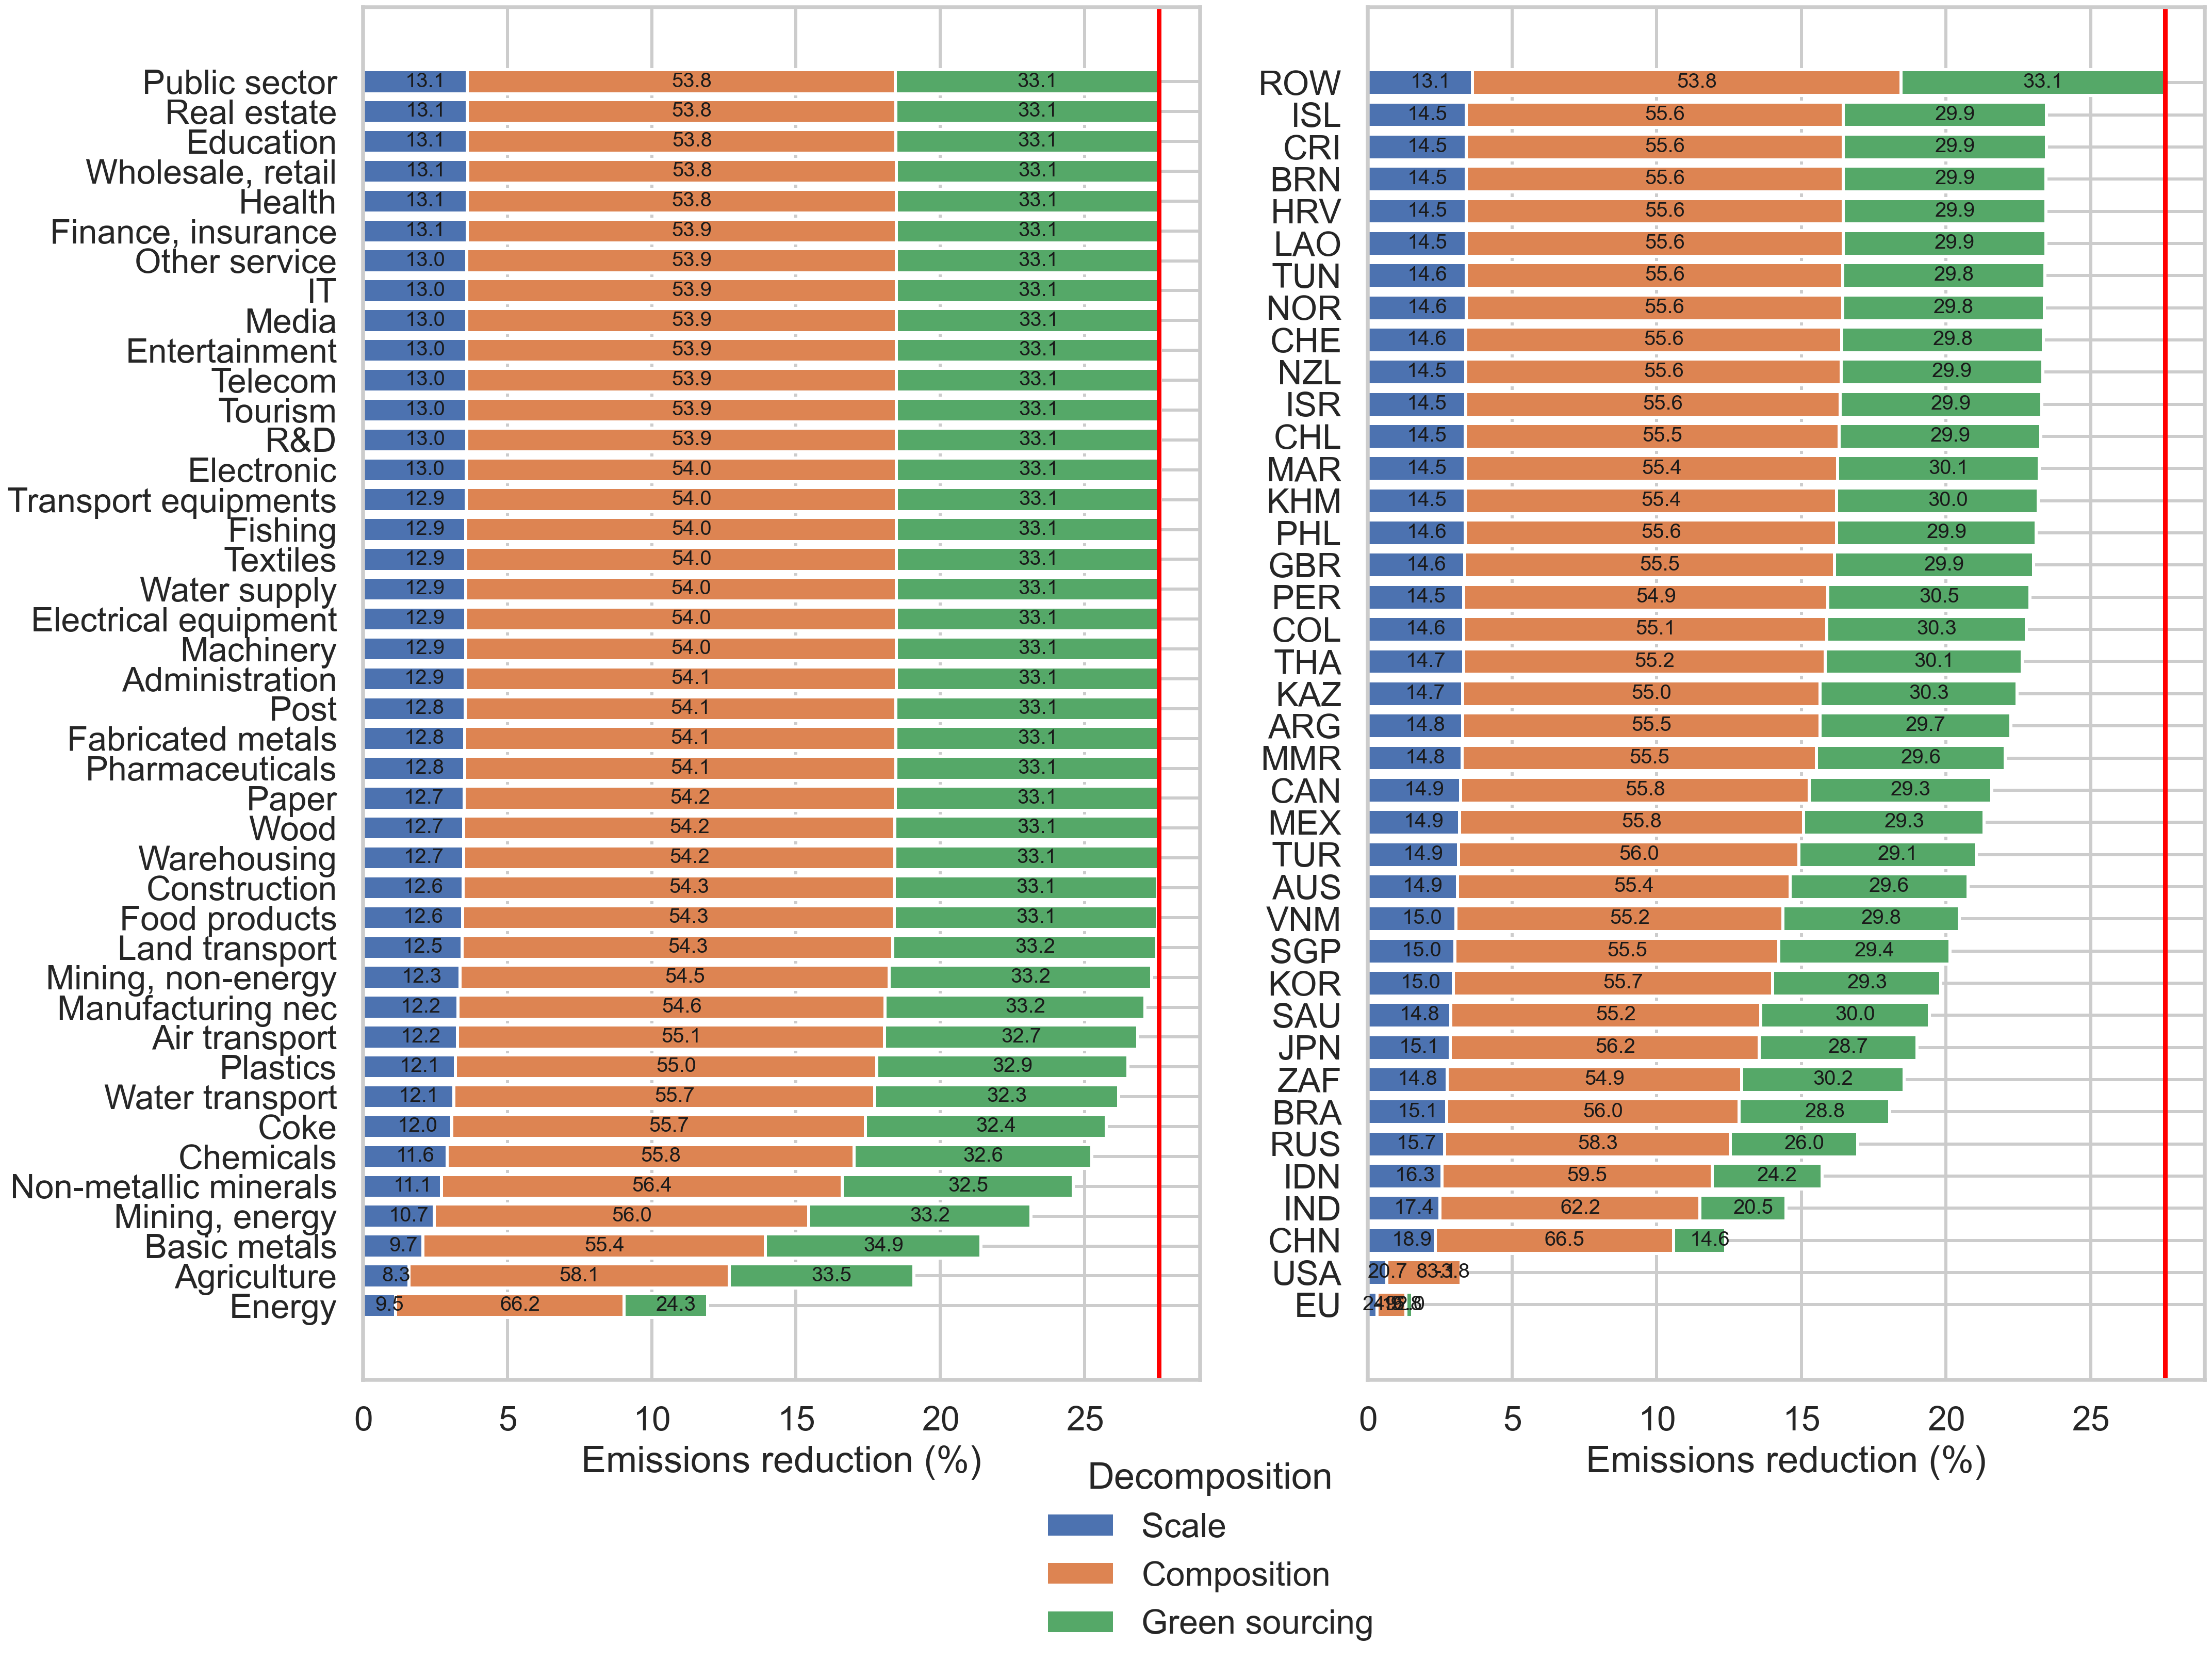

In [149]:
N = baseline.country_number
S = baseline.sector_number
e = baseline.co2_intensity.value.values.reshape((N,S))
save = True

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

sector_map = pd.read_csv(data_path+'industry_labels_after_agg_expl_wgroup.csv')
sector_map['sector'] = sector_map['ind_code'].str.replace('D','')
sector_map.set_index('sector',inplace=True)

idx_cc = -1

fig,ax = plt.subplots(1,2,figsize = (16,12),dpi=288)

sectors = []
for i,sect_list in enumerate(pd.Series(decompositions_by_taxed_sectors.keys()).apply(literal_eval)):
    if i == 0:
        sectors = [sect_list[0]]
    else:
        for s in sect_list:
            if s not in sectors:
                sectors.append(s)

sector_names = [sector_map.loc[s,'industry'] for s in sectors]

t1 = np.zeros(len(sectors))
t2 = np.zeros(len(sectors))
t3 = np.zeros(len(sectors))

baseline_em = baseline.co2_prod.value.sum()
l_em_reduc= -(np.array([sols_by_taxed_sectors[k][idx_cc].run.emissions for k in sols_by_taxed_sectors]) - baseline_em)*100/baseline_em

for j,k in enumerate(decompositions_by_taxed_sectors.keys()):
    sum_terms = decompositions_by_taxed_sectors[k]['term_1']+decompositions_by_taxed_sectors[k]['term_2']+\
        decompositions_by_taxed_sectors[k]['term_3']
    t1[j] = decompositions_by_taxed_sectors[k]['term_1']*l_em_reduc[j]/sum_terms
    t2[j] = decompositions_by_taxed_sectors[k]['term_2']*l_em_reduc[j]/sum_terms
    t3[j] = decompositions_by_taxed_sectors[k]['term_3']*l_em_reduc[j]/sum_terms

sum_t = t1 + t2 + t3

bars1 = ax[0].barh(sector_names,t1,label = 'Scale')
bars2 = ax[0].barh(sector_names,t2,left=t1, label = 'Composition')
bars3 = ax[0].barh(sector_names,t3,left=t1+t2, label = 'Green sourcing')

ax[0].bar_label(bars1,
              labels = [round(t*100/sum_t[i],1) for i,t in enumerate(t1)],
              label_type = 'center',
              padding = 5,
              color = 'k',
              fontsize = 10,
              zorder = 99)
ax[0].bar_label(bars2,
              labels = [round(t*100/sum_t[i],1) for i,t in enumerate(t2)],
              label_type = 'center',
              padding = 5,
              color = 'k',
              fontsize = 10,
              zorder = 99)
ax[0].bar_label(bars3,
              labels = [round(t*100/sum_t[i],1) for i,t in enumerate(t3)],
              label_type = 'center',
              padding = 5,
              color = 'k',
              fontsize = 10,
              zorder = 99)

ax[0].axvline(x=l_em_reduc[-1],
            color='red')
ax[0].set_xlabel('Emissions reduction (%)')

ax[0].legend(loc=(0.8,-0.2),title='Decomposition')

countries = []
for i,count_list in enumerate(pd.Series(decompositions_by_taxed_countries.keys()).apply(literal_eval)):
    if i == 0:
        countries.append('EU')
    else:
        for c in count_list:
            if c not in countries and c not in EU:
                countries.append(c)

t1 = np.zeros(len(countries))
t2 = np.zeros(len(countries))
t3 = np.zeros(len(countries))

baseline_em = baseline.co2_prod.value.sum()
l_em_reduc= -(np.array([sols_by_taxing_countries[k][idx_cc].run.emissions for k in sols_by_taxing_countries]) - baseline_em)*100/baseline_em

for j,k in enumerate(decompositions_by_taxed_countries.keys()):
    sum_terms = decompositions_by_taxed_countries[k]['term_1']+decompositions_by_taxed_countries[k]['term_2']+\
        decompositions_by_taxed_countries[k]['term_3']
    t1[j] = decompositions_by_taxed_countries[k]['term_1']*l_em_reduc[j]/sum_terms
    t2[j] = decompositions_by_taxed_countries[k]['term_2']*l_em_reduc[j]/sum_terms
    t3[j] = decompositions_by_taxed_countries[k]['term_3']*l_em_reduc[j]/sum_terms

sum_t = t1 + t2 + t3
twn_idx = countries.index('TWN')
t1 = np.delete(t1,twn_idx)
t2 = np.delete(t2,twn_idx)
t3 = np.delete(t3,twn_idx)
sum_t = np.delete(sum_t,twn_idx)
countries.remove('TWN')

bars1 = ax[1].barh(countries,t1,label = 'Scale')
bars2 = ax[1].barh(countries,t2,left=t1, label = 'Composition')
bars3 = ax[1].barh(countries,t3,left=t1+t2, label = 'Green sourcing')

# ax[1].bar_label(bars3,
#               labels=countries,
#               label_type = 'edge',
#               padding=5,
#               fontsize=15,
#               zorder=99)

ax[1].bar_label(bars1,
              labels = [round(t*100/sum_t[i],1) for i,t in enumerate(t1)],
              label_type = 'center',
              padding = 5,
              color = 'k',
              fontsize = 10,
              zorder = 99)
ax[1].bar_label(bars2,
              labels = [round(t*100/sum_t[i],1) for i,t in enumerate(t2)],
              label_type = 'center',
              padding = 5,
              color = 'k',
              fontsize = 10,
              zorder = 99)
ax[1].bar_label(bars3,
              labels = [round(t*100/sum_t[i],1) for i,t in enumerate(t3)],
              label_type = 'center',
              padding = 5,
              color = 'k',
              fontsize = 10,
              zorder = 99)

ax[1].axvline(x=l_em_reduc[-1],
            color='red')
ax[1].set_xlabel('Emissions reduction (%)')

# ax[1].legend(loc=(0,-0.2),title='Decomposition')

# plt.tight_layout()

if numeraire == 'world_wage' and elasticities_path == 'cp_estimate_allyears.csv':
    if save or save_all:
        plt.savefig(save_path+'incremental_real_decompositions.'+save_format,format=save_format)

plt.show()

# Path to net zero plot

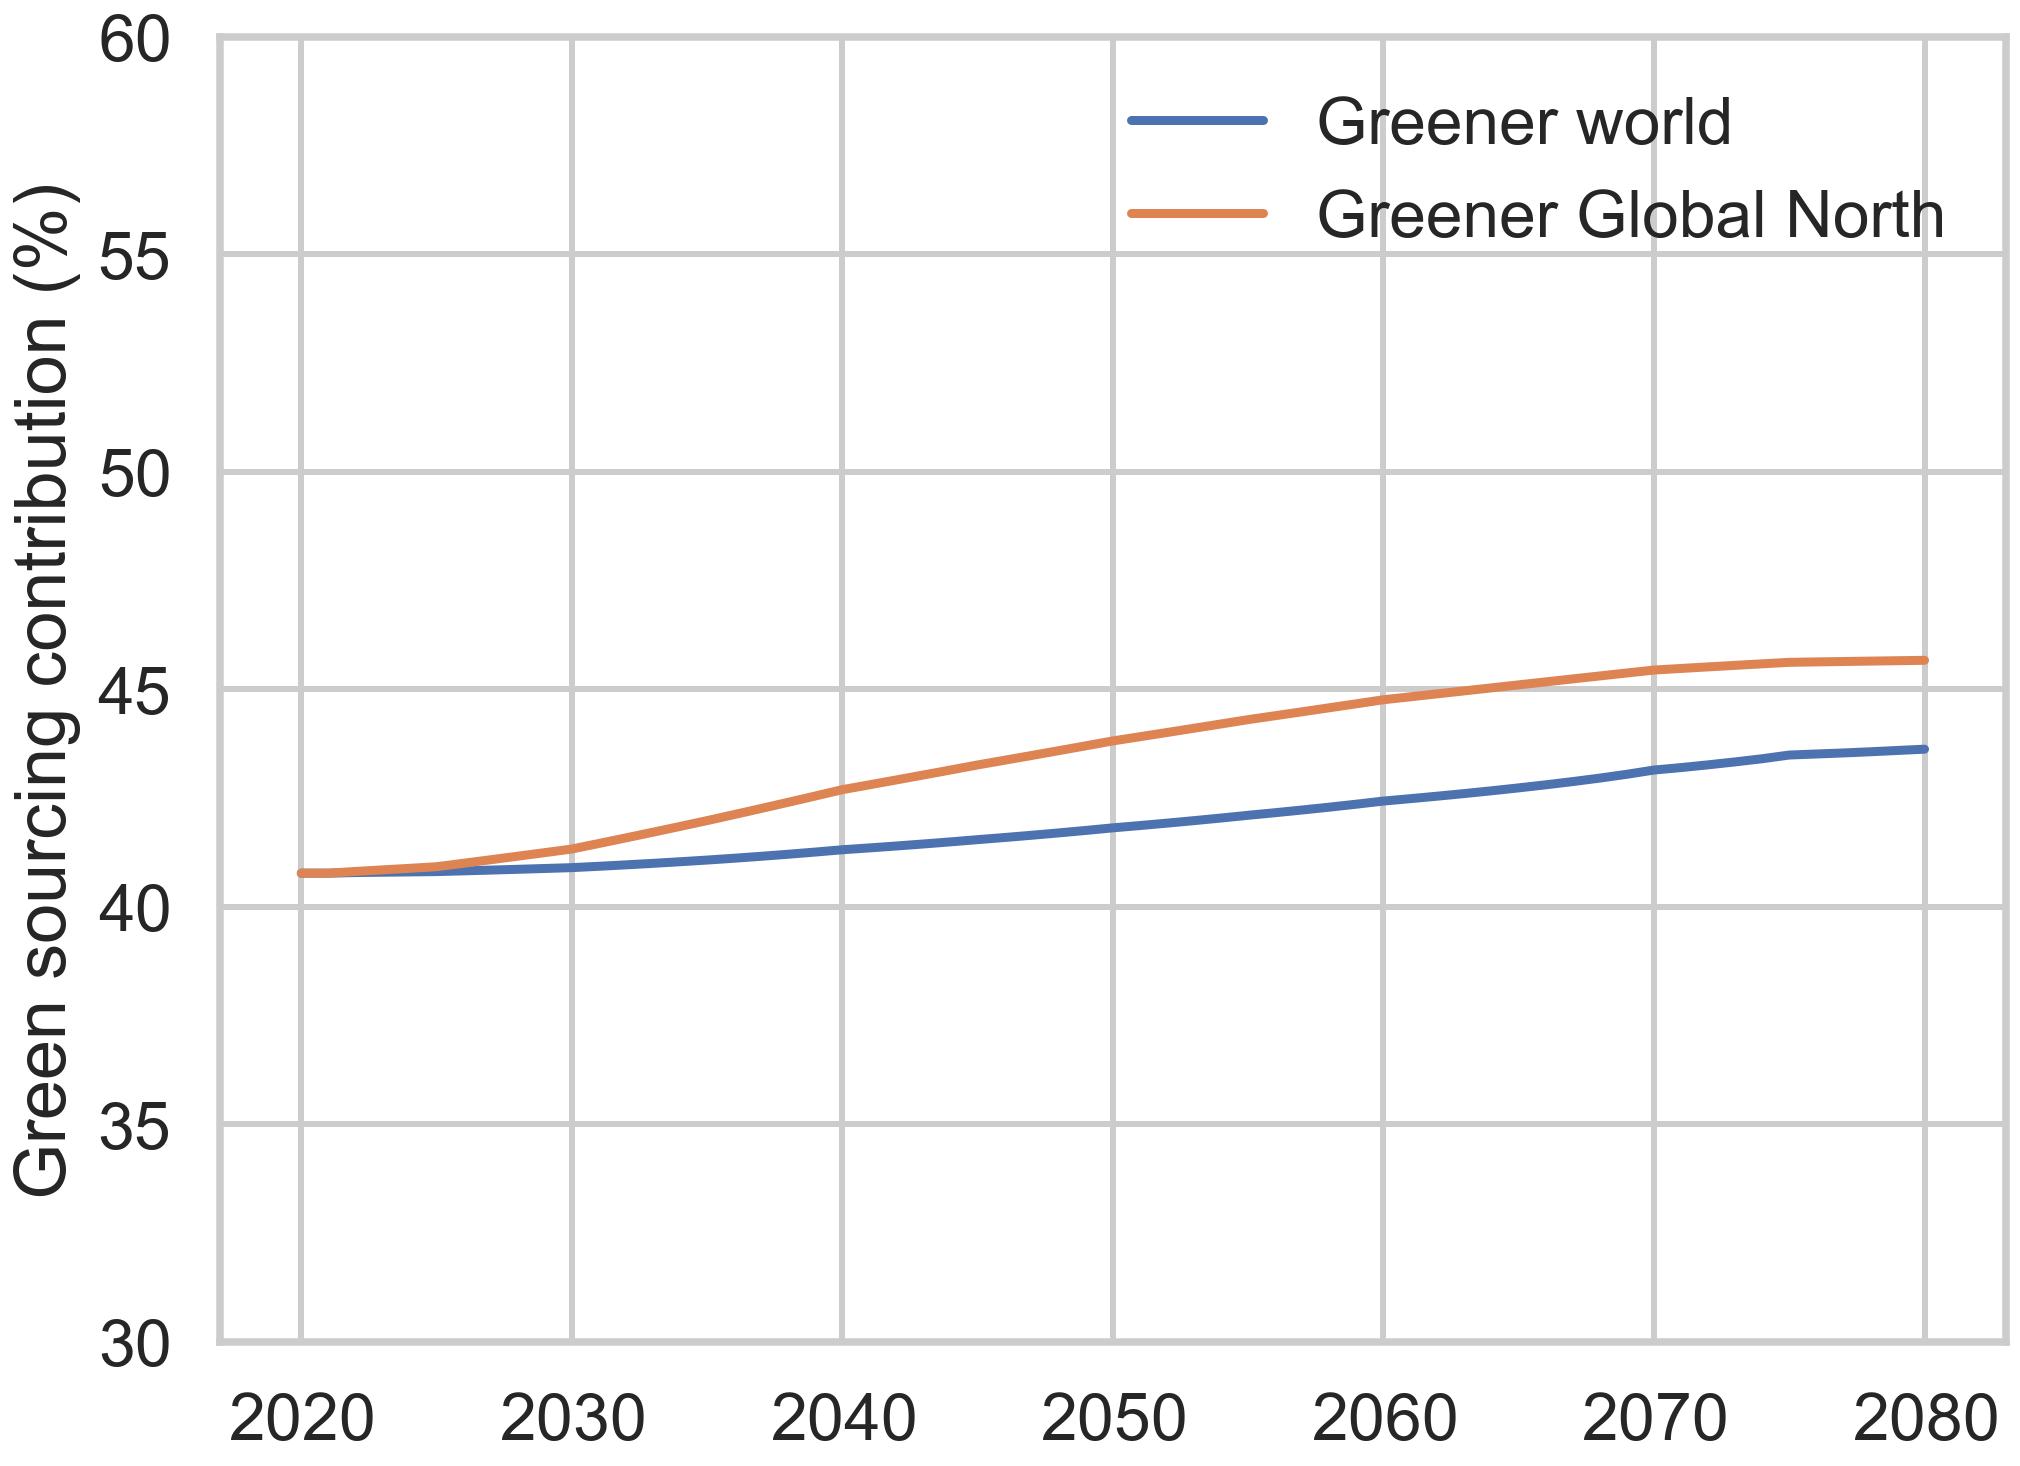

In [25]:
df = pd.read_csv('results/technological_projection.csv')
df = df[df.years>=2020]
df = df[df.years<=2080]

df.loc[df.years<2022,'north contrib term 3'] = df.loc[df.years<2022,'world contrib term 3']

fig,ax = plt.subplots(figsize = (8,6),dpi = 288)

ax.plot(df.years,df['world contrib term 3']*100,label='Greener world')
ax.plot(df.years,df['north contrib term 3']*100,label='Greener Global North')

ax.legend()
ax.set_ylabel('Green sourcing contribution (%)')
ax.set_ylim(30,60)

if save or save_all:
    plt.savefig(save_path+'technological_projection.'+save_format,
                format=save_format)

plt.show()